In [1]:
import pandas as pd
# Import
from pandarallel import pandarallel

# Initialization
pandarallel.initialize()

import os
import json
# !pip install pywer
import pywer
# !pip install pyjarowinkler
from pyjarowinkler import distance as jwdistance
from tqdm import tqdm

class Const:
    OCR = 'ocr'
    GROUND = 'groundtruth'
    REGION = 'region'
    LINE = 'line'
    SENTENCE = 'sentence'
    FILE = 'filename'
    DATASET = 'dataset_name'
    PREDICTION = 'prediction'
    PROMPT = 'prompt'
    LANGUAGE = 'language'
    NONE = None


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### Lookup datasets

In [2]:
datasets = []

for type_document in ['ocr', 'htr', 'asr']:
    for root, dirs, files in os.walk(f'../data/datasets/{type_document}/converted'):
        for file in files:
            if file.endswith(".jsonl"):
                input_file = os.path.join(root, file)
                if 'sample' not in input_file:
                    with open(input_file) as f:
                        lines = f.read().splitlines()
                    df_inter = pd.DataFrame(lines)
                    df_inter.columns = ['json_element']
                    df_inter['json_element'].apply(json.loads)
                    df = pd.json_normalize(df_inter['json_element'].apply(json.loads))

                    dataset_name = root.split('/')[-1].replace('_', '-')
                    print(input_file, dataset_name)
                    df['dataset_name'] = [dataset_name] * len(df)
                    if 'ajmc' in dataset_name:
                        df['language'] = ['el'] * len(df)
                    if 'overproof' in dataset_name:
                        df['language'] = ['en'] * len(df)
                    if 'impresso' in dataset_name:
                        df['language'] = ['de'] * len(df)

                    datasets.append(df)
            

../data/datasets/ocr/converted/ajmc-mixed/ajmc_mixed.jsonl ajmc-mixed
../data/datasets/ocr/converted/overproof/overproof.jsonl overproof
../data/datasets/ocr/converted/icdar-2019/icdar-2019.jsonl icdar-2019
../data/datasets/ocr/converted/icdar-2017/icdar-2017.jsonl icdar-2017
../data/datasets/ocr/converted/impresso/impresso-nzz.jsonl impresso
../data/datasets/ocr/converted/ajmc-primary/ajmc_primary_text.jsonl ajmc-primary
../data/datasets/htr/converted/htrec/htrec.jsonl htrec
../data/datasets/asr/converted/ina/ina.jsonl ina


In [3]:
print('Number of unique lines/sentences/regions.\n')
for dataset in datasets:
    print('Dataset:', dataset['dataset_name'].unique()[0], len(dataset), 'with duplicates')
    print('No. lines:', dataset['ocr.line']. nunique(), '/', len(dataset['ocr.sentence']), 
          'No. sentences:', dataset['ocr.sentence']. nunique(), '/', len(dataset['ocr.sentence']), 
          'No. regions:', dataset['ocr.region']. nunique(), '/', len(dataset['ocr.region']))
    print('-'*80)

Number of unique lines/sentences/regions.

Dataset: ajmc-mixed 1291 with duplicates
No. lines: 535 / 1291 No. sentences: 379 / 1291 No. regions: 33 / 1291
--------------------------------------------------------------------------------
Dataset: overproof 2669 with duplicates
No. lines: 2278 / 2669 No. sentences: 399 / 2669 No. regions: 41 / 2669
--------------------------------------------------------------------------------
Dataset: icdar-2019 404 with duplicates
No. lines: 0 / 404 No. sentences: 404 / 404 No. regions: 41 / 404
--------------------------------------------------------------------------------
Dataset: icdar-2017 477 with duplicates
No. lines: 0 / 477 No. sentences: 461 / 477 No. regions: 28 / 477
--------------------------------------------------------------------------------
Dataset: impresso 1563 with duplicates
No. lines: 1256 / 1563 No. sentences: 577 / 1563 No. regions: 203 / 1563
--------------------------------------------------------------------------------
Data

## Step 1: Loading of preliminary results


In [4]:
def read_line_by_line(filename):
    pass

def json_load(text):
    
    try:
        loaded_line = json.loads(text)
    except Exception as ex:
        print(ex)
        print(text[:30], '...')
        loaded_line = 'No text'
    return loaded_line

In [5]:
def get_icdar_2017_lang(filename):
    lang = filename.split('/')[-2].split('_')[0]
    if lang =='eng':
        lang = 'en'
    return lang

In [ ]:
import gc; gc.collect()
from tqdm import tqdm
import os

results = []

# First traversal to get count of .jsonl files
jsonl_count = 0
for root, dirs, files in os.walk('../data/output'):
    for file in files:
        if file.endswith(".jsonl"):
            jsonl_count += 1

# Second traversal to do the processing with tqdm progress bar
with tqdm(total=jsonl_count) as pbar:
    for root, dirs, files in os.walk('../data/output'):
        for file in files:
            if file.endswith(".jsonl"):
                input_file = os.path.join(root, file)
                is_few = False
                if 'few' in input_file:
                    prompt = root.split('/')[-2]
                    is_few = True
                else:
                    prompt = root.split('/')[-2]
                    
                if 'sample' not in input_file:
                    if 'prompt_complex_lang' in input_file:
                        print(input_file)
#                     prompt = root.split('/')[-2]
                    try:
                        with open(input_file) as f:
                            text = f.read()
                    
                        with open(input_file) as f:
                            lines = f.readlines()
                    except Exception as ex:
                        print('We could not load {} {}'.format(input_file, ex))
                        continue
                    # Check correct lines
                    text = text.replace('\n', '')
                    text_list = text.split('}}{"')
                    json_objects = []

                    for i, t in enumerate(text_list):
                        if i != 0:
                            t = '{"' + t
                        if i != len(text_list) - 1:
                            t = t + '}'
                        if not t.endswith('}}'):
                            json_objects.append(t + '}\n')
                        else:
                            json_objects.append(t + '\n')
                        
                    df_inter = pd.DataFrame(json_objects)
                    df_inter.columns = ['json_element']

                    dataset_name = root.split('/')[-1].replace('_', '-')
                    model_dataset_name = file[8:-6]
                    model_name = model_dataset_name.replace(root.split('/')[-1] + '-', '').strip()
                    try:
                        df_inter['json_element'].apply(lambda x: json_load(x))
                        df = pd.json_normalize(df_inter['json_element'].apply(json.loads))

                        df['model'] = [model_name] * len(df)

                        df['dataset_name'] = [dataset_name] * len(df)
                        df['prompt'] = [prompt] * len(df)
                        try:
                            with open(f'../data/prompts/{prompt}.txt', 'r') as f:
                                prompt_text = f.read()
                        except:
                            prompt_text = 'prompt_complex_03_per_lang'
                            
                        df['prompt_text'] = [prompt_text] * len(df)
                        
                        if is_few:
                            df['type'] = ['few-shot'] * len(df)
                        else:
                            df['type'] = ['zero-shot'] * len(df)

                        df['dataset_name'] = [dataset_name] * len(df)
                        
                        if 'ajmc' in dataset_name:
                            df['language'] = ['el'] * len(df)
                        if 'ina' in dataset_name:
                            df['language'] = ['fr'] * len(df)
                        if 'overproof' in dataset_name:
                            df['language'] = ['en'] * len(df)
                        if 'impresso' in dataset_name:
                            df['language'] = ['de'] * len(df)
                        if 'htrec' in dataset_name:
                            df['language'] = ['el'] * len(df)

#                         print(dataset_name, model_name, prompt)

                        if dataset_name == 'icdar-2017':
                            df['language'] = df['filename'].apply(get_icdar_2017_lang)
                        
                        results.append(df)
#                         print(df.prompt.unique())
                    except Exception as ex:
                        print('We could not load {} {}'.format(input_file, ex))
                    pbar.update()


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 257/471 [01:34<00:25,  8.27it/s]

Expecting value: line 1 column 1 (char 0)
}
 ...
We could not load ../data/output/few_shot/prompt_complex_03/icdar-2019/results-3few-shot-icdar-2019-gpt-4.jsonl Expecting value: line 1 column 1 (char 0)


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 263/471 [01:36<00:36,  5.64it/s]

In [7]:
results[0].head()

,filename,dataset_name,ocr.line,ocr.sentence,ocr.region,groundtruth.line,groundtruth.sentence,groundtruth.region,prediction.prompt,prediction.line,prediction.sentence,prediction.region,model,prompt,prompt_text,type,language
0,../../data/datasets/ocr/original/impresso-nzz/...,impresso-nzz,Pränumeration.,Pränumeration.,Pränumeration.,Pränumeration.,Pränumeration.,Pränumeration.,Correct the spelling and grammar of the follow...,30.5 The spelling and grammar is corrected.\n30.6,30.5 The spelling and grammar is corrected.\n30.6,30.5 The spelling and grammar is corrected.\n30.6,decapoda-research-llama-7b-hf,prompt_basic_02,Correct the spelling and grammar of the follow...,zero-shot,de
1,../../data/datasets/ocr/original/impresso-nzz/...,impresso-nzz,Pränumeration.,Pränumeration.,Pränumeration.,Pränumeration.,Pränumeration.,Pränumeration.,NaN,30.5 The spelling and grammar is corrected.\n30.6,30.5 The spelling and grammar is corrected.\n30.6,30.5 The spelling and grammar is corrected.\n30.6,decapoda-research-llama-7b-hf,prompt_basic_02,Correct the spelling and grammar of the follow...,zero-shot,de
2,../../data/datasets/ocr/original/impresso-nzz/...,impresso-nzz,Jährlich............. 8 Fr.,Jährlich.............,Jährlich............. 8 Fr.,Jährlich............. 8 Fr.,Jährlich.............,Jährlich............. 8 Fr.,Correct the spelling and grammar of the follow...,69.99 EUR 55.55 EUR 125.9,ine...........Ausstellung............der.........,69.99 EUR 55.55 EUR 125.9,decapoda-research-llama-7b-hf,prompt_basic_02,Correct the spelling and grammar of the follow...,zero-shot,de
3,../../data/datasets/ocr/original/impresso-nzz/...,impresso-nzz,Jährlich............. 8 Fr.,Jährlich.............,Jährlich............. 8 Fr.,Jährlich............. 8 Fr.,Jährlich.............,Jährlich............. 8 Fr.,NaN,69.99 EUR 55.55 EUR 125.9,ine...........Ausstellung............der.........,69.99 EUR 55.55 EUR 125.9,decapoda-research-llama-7b-hf,prompt_basic_02,Correct the spelling and grammar of the follow...,zero-shot,de
4,../../data/datasets/ocr/original/impresso-nzz/...,impresso-nzz,Jährlich............. 8 Fr.,8 Fr.,Jährlich............. 8 Fr.,Jährlich............. 8 Fr.,8 Fr.,Jährlich............. 8 Fr.,Correct the spelling and grammar of the follow...,69.99 EUR 55.55 EUR 125.9,(20%) 1. The book we studied yesterday was ___...,69.99 EUR 55.55 EUR 125.9,decapoda-research-llama-7b-hf,prompt_basic_02,Correct the spelling and grammar of the follow...,zero-shot,de


## Post-process

In [8]:
import Levenshtein
from Levenshtein import distance

def compute_normalized_levenshtein_similarity(ocr_text, ground_truth_text):
    length = max(len(ocr_text), len(ground_truth_text))
    levenshtein_distance = distance(ocr_text, ground_truth_text)
    similarity = (length - levenshtein_distance) / length
    return similarity

def compute_jaccard(ocr_text, ground_truth_text):
    try: 
        return jwdistance.get_jaro_distance(ocr_text, ground_truth_text)
    except:
        return 0.0

def get_improvement(original_similarity, corrected_similarity):
    
    if original_similarity == 0:
        return min(max(corrected_similarity, -1), 1)
    elif original_similarity != corrected_similarity:
        return min(max((corrected_similarity - original_similarity) / original_similarity, -1), 1)
    elif original_similarity == corrected_similarity:
        return 0
    else:
        return 0 if corrected_similarity < 1 else 1


In [9]:
gt_text = "149 Obrázek z maloměstského kukátka. Podává L. Gro"
ocr_text = "149 Obrázek z maloměstského kukátka. Podává L. Grw"
pred_text = """Correct the text: "149 Obrázek z maloměstského kukátka. Podává L. Grwsmannová-Brodská. Místo děje: salon paní stavitelky; doba: čas věnovaný kávové „visitě"; jednající osoby: dámy přednější honorace městské, z nichž •většina je mladá a některé skutečně hezké. Na stole prostřeném krásným ubrusem damaškovým stojí talíře s koláčky, věnečky a preclíčky, kol toho pěkně se vyjímají křišťálové sklenky s vodou, stříbrné lžičky a šálky z jemného porcelánu, jejichž vonný obsah na přítomné paničky zdá se velmi blaze působiti. Ze živějšího hovoru vyznívá právě hlas paní notářky, která ve spravedlivém rozhorlení mluví: „Ano, mé dámy, již jest to takové! Samy ráčily jste býti svědky, jak svorně i jednohlasně byl přijat návrh paní sládkové, abychom si pořídily kroje národní a tak přispěly ku zvýšení lesku slavnosti, již pořádá náš statečný studentský spolek „Hvězda", a když již nás páni akademikové poctili důvěrou, že v naše ruce složili starost o buffet a jiné ještě funkce, tož měly bychom snad též jiti za příkladem slečen berních a vzdáti se činnosti jen proto, že se zdá paní berní národní kroj pro tři dcery býti nějakou zby tečnou výlohou?" Paničky projevovaly svoji nevoli, každá jiným spůsobem. Mladá paní adjunktová v duchu si umiňovala, že ve svém přátel ství k berňovům trochu ochladne; to tak! aby ten jejich pošetilý nápad, úóinkovati při slavnosti v obyčejném oděvu, přece zvítězil a dámám se bylo odříci těch půvabných krojů venkovských, co by si jen ona, paní adjunktová, počala s tou haldou brokátu, atlasu, krajek, stuh a aksamitu, za což vydala nejednu desítku, utěšujíc se tím, jak jí to bude slušeti! Hm, a škodu z toho také míti nebude, muž se bude musit po několik měsíců uskrovnit, služka se má beztoho též až příliš dobře, uhradí se to na domácnosti a bude! Nyní ujala se slova paní doktorka: „Aj, od berních to není nic divného, považte jen: tolik dětí! Vždyť my všecky víme, že kdyby sobě slečny toillety samy ne řídily, mnohého by nemohly míti; ony pak mají zásadu: nemá-li být něco pěkné, tož raději nic!" „Pravda, ale slečny Elišky, té nejmladší, jest mně líto; těšila se velice na selský kroj." „Ba ano, byla by v něm vypadala roztomile." „Nyní má po radosti." „Inu, proč má tak nepřející matinku." „To není to, má drahá, jest v tom však jiný háček." „Ah, ano; vždyť víme, že sotva tak tak vyjdou." „Ale na knihy, které jsi tvá, jinak našel byste jen krytí těch mladých mozí, jinak je vydáte." „A tak bude, ostatně jdu až na knihy; ale slyšet jsem od někoho, že o krojech něco dělat, a že to bylo bude dělat národní, a když jsi tento národní učil jak, pak by měl nalézt tuto kartu, ta by se jistě mohla vyměnit se všemi. Můžete-li to od nás odkázat?" Všem ozdravila její hlas, když řekla: „Já, já! a já ho učím. S těmi páne akademiky jsem již mohla vyprávět o světě, v němž vznítí v některé nocy a jednoho dne vyrostá vám hrozný kouzelný strom zůstane, o němž je psáno: ‚Už jen žádat!" 50 V tuto chvíli koupili mohou-li všichni pánové i paní, že když jsi to čerpala, dá se jen kupit. Přižili to, a já jim vám koupi ukáži.
„A já už jste tím vyděštila. Pánové, děkuji vám za chytré vědomí, se kterým vám projeví, že se už točí dívčí zrcadlo." – 151"""
                
get_improvement(compute_normalized_levenshtein_similarity(gt_text, ocr_text), 
                compute_normalized_levenshtein_similarity(gt_text, pred_text))




-0.9839406962029382

In [10]:
gt_text = "302."
ocr_text = "302."
pred_text = "302."

get_improvement(compute_normalized_levenshtein_similarity(gt_text, ocr_text), 
                compute_normalized_levenshtein_similarity(gt_text, pred_text))



0

In [11]:
gt_text = 'testing'
ocr_text = 'resting'
pred_text = 'testing'

compute_normalized_levenshtein_similarity(gt_text, ocr_text), distance(gt_text, ocr_text)

(0.8571428571428571, 1)

In [12]:
get_improvement(compute_normalized_levenshtein_similarity(gt_text, ocr_text), 
                compute_normalized_levenshtein_similarity(gt_text, pred_text))


0.16666666666666674

In [13]:
import Levenshtein

# Example strings
s1 = "testing"
s2 = "resting"

# Calculate the Levenshtein distance
lev_distance = Levenshtein.distance(s1, s2)
print(f"Levenshtein distance: {lev_distance}")

# Calculate the Levenshtein similarity
similarity = (max(len(s1), len(s2)) - lev_distance) / max(len(s1), len(s2))
print(f"Levenshtein similarity: {similarity:.2f}")


Levenshtein distance: 1
Levenshtein similarity: 0.86


In [14]:
def postprocess_segment_type(segment_type):
    def postprocess(row):
        pred_text = row[f'prediction.{segment_type}']
        ground_text = row[f'groundtruth.{segment_type}']
        prompt_text = row['prompt_text']
        
        if pred_text is not None:
            if type(pred_text) == str:
                if len(pred_text.strip()) > 0:
                    if pred_text.startswith('"'):
                        pred_text = pred_text[1:]
                    if pred_text.endswith('"'):
                        pred_text = pred_text[:-1]
                
                empty_prompt_text = prompt_text.replace('{{TEXT}}', '').strip()
                
                if prompt_text in pred_text:
                    pred_text = pred_text.replace(prompt_text, '').strip()
                prompt_text_empty = prompt_text.replace("{{TEXT}}", '').strip()
                if prompt_text_empty in pred_text:
                    pred_text = pred_text.replace(prompt_text_empty, '').strip()
#                     print(prompt_text_empty)
                prompt_text = prompt_text.replace("{{TEXT}}", pred_text)
                if prompt_text in pred_text:
                    pred_text = pred_text.replace(prompt_text, '').strip()
                pred_text = pred_text.strip()
                if empty_prompt_text in pred_text:
                    pred_text = pred_text.replace(empty_prompt_text, '')
                    print(empty_prompt_text)
                if 'Corrected text:' in pred_text:
                    pred_text = pred_text.replace('Corrected text:', '')
                if 'Corrected text is:' in pred_text:
                    pred_text = pred_text.replace('Corrected text is:', '')
                if 'The corrected text:' in pred_text:
                    pred_text = pred_text.replace('The corrected text:', '')
                if 'The corrected text is:' in pred_text:
                    pred_text = pred_text.replace('The corrected text is:', '')
                # Cut the pred_text to the length of the ground_text
                pred_text = pred_text[:len(ground_text) + len(ground_text)//4].strip()

        return pred_text
    return postprocess

## Step 2: Generating LEV similarities 

In [15]:
for idx, result in tqdm(enumerate(results), total=len(results)):
    
    try:
        results[idx] = results[idx].fillna('No text')
    except:
        pass
    
    dataset_name = results[idx]['dataset_name'].unique()[0]
    model_name = results[idx]['model'].unique()[0]
    prompt = results[idx]['prompt'].unique()[0]
    
#     print('Dataset:', dataset_name, 'Model:', model_name, 'Prompt:', prompt)
    
    if 'icdar' in dataset_name:
        text_types = ['sentence', 'region']
    else:
        text_types = ['line', 'sentence', 'region']
    for segment_type in text_types:
        try:
            results[idx]['length'] = results[idx][f'groundtruth.{segment_type}'].str.len()
            results[idx] = results[idx][results[idx]['length'] > 3]

            postprocess = postprocess_segment_type(segment_type)
            result[f'prediction.{segment_type}'] = result.apply(postprocess, axis=1)

            # Compute Lev similarity
            results[idx][f'{segment_type}-lev-ocr'] = \
                results[idx].parallel_apply(lambda x: compute_normalized_levenshtein_similarity(x[f'groundtruth.{segment_type}'],
                                                                                     x[f'ocr.{segment_type}']), axis=1)
            results[idx][f'{segment_type}-lev-pred'] = \
                results[idx].parallel_apply(lambda x: compute_normalized_levenshtein_similarity(x[f'groundtruth.{segment_type}'],
                                                                                     x[f'prediction.{segment_type}']), axis=1)

            results[idx][f'{segment_type}-lev-improvement'] = \
                results[idx].parallel_apply(lambda x: get_improvement(x[f'{segment_type}-lev-ocr'],
                                                             x[f'{segment_type}-lev-pred']), axis=1)
        except Exception as ex:
            print(ex)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 470/470 [16:10<00:00,  2.07s/it]


In [16]:
len(results)

470

## Step 3: Preparing the final results (results concatenation + generating quality bands, etc.)


In [17]:
data = pd.concat(results)

len(data)

348352

In [18]:
MODEL_MAP = {'gpt-4':'GPT-4', 'gpt-3.5-turbo':'GPT-3.5', 'facebook-opt-350m':'OPT',
       'bigscience-bloom-560m':'BLOOM', 'decapoda-research-llama-7b-hf':'LLaMA',
       'davinci':'GPT-3', 'gpt2':'GPT-2', 'tloen-alpaca-lora-7b':'Alpaca', 
            '3few-shot-gpt-4': 'GPT-4', '3few-shot-gpt-3.5-turbo': 'GPT-3.5', '3few-shot-davinci': 'GPT-3',
            '3few-shot-gpt2': 'GPT-2', '3few-shot-facebook-opt-350m': 'OPT', 
            'ajmc_primary_text-gpt-4': 'GPT-4', 
            'ajmc_primary_text-bigscience-bloom-560m': 'BLOOM', 
            'ajmc_primary_text-decapoda-research-llama-7b-hf': 'LLaMA', 
            'ajmc_primary_text-davinci': 'GPT-3', 
            'ajmc_primary_text-facebook-opt-350m': "OPT",
            'ajmc_primary_text-gpt2': 'GPT-2',
            'ajmc_primary_text-gpt-3.5-turbo': 'GPT-3.5', 
            'ajmc_mixed-decapoda-research-llama-7b-hf': 'LLaMA',
            'ajmc_mixed-bigscience-bloom-560m': 'BLOOM',
            'ajmc_mixed-gpt2': 'GPT-2',
            'ajmc_mixed-facebook-opt-350m': 'OPT',
            'ajmc_mixed-gpt-4': 'GPT-4',
            'ajmc_mixed-davinci': 'GPT-3',
            'ajmc_mixed-gpt-3.5-turbo': 'GPT-3.5',
            '3few-shot-bigscience-bloom-560m': 'BLOOM',
            '3few-shot-decapoda-research-llama-7b-hf': 'LLaMA'}

data['model'] = data['model'].apply(lambda x: MODEL_MAP[x])

In [19]:
data.model.unique()


array(['LLaMA', 'GPT-3', 'BLOOM', 'OPT', 'GPT-4', 'GPT-3.5', 'GPT-2'],
      dtype=object)

In [20]:
data.prompt.unique()


array(['prompt_basic_02', 'prompt_complex_01', 'prompt_basic_01',
       'prompt_complex_02', 'prompt_complex_lang', 'prompt_complex_03',
       'prompt_complex_03_ina_fr'], dtype=object)

In [21]:
# Define OCR noise level bins
bins = [0, 0.4, 0.6, 0.8, 0.99, 1.0]

# Assign OCR noise level labels
labels = ["0-40%", "40-60%", "60-80%", "80-99%", "99-100%"]

# Create a new column for the OCR noise level bins
data[f"Quality Band"] = pd.cut(data[f'region-lev-ocr'], bins=bins, labels=labels, include_lowest=True)

In [22]:
data[f"Quality Band"].unique()


['99-100%', '80-99%', '0-40%', '60-80%', '40-60%']
Categories (5, object): ['0-40%' < '40-60%' < '60-80%' < '80-99%' < '99-100%']

In [23]:
# Add Overall Levenshtein Improvement
data[f'Overall Levenshtein Improvement'] = data[[f'line-lev-improvement', 
                                                 f'sentence-lev-improvement', 
                                                 f'region-lev-improvement']].mean(axis=1)



In [24]:
# Custom binning function
def bin_improvement(x):
    if x < 0:
        return "Negative Improvement"
    elif x == 0:
        return "No Improvement"
    elif x > 0:
        return "Positive Improvement"

# Apply the function
data['Improvement Band'] = data['Overall Levenshtein Improvement'].apply(bin_improvement)



# Sampling

## Sampling for few-shot (commented out)

In [25]:
# import numpy as np
# import pandas as pd
# from tqdm import tqdm

# # Define five distinct quality bands
# quality_bands = ["0-40%", "40-60%", "60-80%", "80-99%", "99-100%"]

# # Initialize an empty list for samples
# all_samples = []

# folder_few_shot = '../data/prompts/few_shot/'

# # Iterate over all unique datasets
# for dataset in tqdm(['ina'], total=len(['ina'])):
# # for dataset in tqdm(data['dataset_name'].unique(), total=len(data['dataset_name'].unique())):
    
    
#     # Get the unique languages for the current dataset
#     languages = data[data['dataset_name'] == dataset]['language'].unique()
#     prompts = data[data['dataset_name'] == dataset]['prompt'].unique()
    
#     print(len(data[data['dataset_name']==dataset]))
#     # Iterate over each unique language
#     for language in languages:
#         # Iterate over each unique prompt
#         for prompt in prompts:
#             sample_list = []
            
#             output_folder = os.path.join(folder_few_shot, dataset)
#             if not os.path.exists(output_folder):
#                 os.makedirs(output_folder)
            
#             # Repeat the sampling process until we have 3 samples
#             while len(sample_list) < 3:
#                 # Iterate over each unique quality band
#                 for quality_band in quality_bands:
                    
#                     # Filter the data to only include rows that match the current dataset, language, prompt, and quality band
#                     subset = data[(data['dataset_name'] == dataset) 
#                                   & (data['language'] == language)
#                                   & (data['prompt'] == prompt)
#                                   & (data['Quality Band'] == quality_band)
#                                   & (data['prediction.prompt'] != 'No text')
#                                   & (data['groundtruth.sentence'].str.len() > 10)]
                    
#                     # If the subset is not empty and we need more samples, take a sample
#                     if not subset.empty and len(sample_list) < 3:
#                         sample = subset.sample(1, random_state=1)
# #                         print(sample)
#                         sample_list.append(sample)
#                 # Break the loop if we already have 3 samples
#                 if len(sample_list) >= 3:
#                     break

#             all_samples.extend(sample_list)
#             if 'icdar' in dataset_name:
#                 text_types = ['sentence', 'region']
#             else:
#                 text_types = ['line', 'sentence', 'region']
            
# #             Generating prompts
#             print(prompt)
#             for segment_type in text_types:
#                 output_file = os.path.join(output_folder, f'{prompt}_{segment_type}_{language}.txt')
#                 with open(output_file, 'w') as f:
#                     for sample in sample_list:
#                         sample = sample.iloc[0]
#                         prompt_text = sample['prompt_text'].replace('{{TEXT}}', sample[f'ocr.{segment_type}'])
#                         correct_text = sample[f'groundtruth.{segment_type}']
#                         f.write(f'{prompt_text}\n\n{correct_text}\n\n')
#                         f.write(sample['prompt_text'])

# # Concatenate all the samples into a single DataFrame
# sample_df = pd.concat(all_samples, ignore_index=True)



## Sampling for analysis

In [26]:
# import numpy as np
# import pandas as pd
# from tqdm import tqdm

# dataset_names = data.dataset_name.unique()
# quality_bands = ["0-40%", "40-60%", "60-80%", "80-99%", "99-100%"]

# sample_list = []
# # Iterate over all unique datasets
# for dataset in tqdm(dataset_names, total = len(dataset_names)):
#     # Get the unique languages for the current dataset
#     languages = data[data['dataset_name'] == dataset]['language'].unique()
#     print(dataset)
#     # Iterate over each unique language
#     for language in languages:
#         print('  --', language)
#         groundtruth_samples = data[(data['dataset_name'] == dataset) 
#                                    & (data['language'] == language)
#                                    & (data['groundtruth.sentence'].str.len() > 10)].drop_duplicates(subset=['groundtruth.line', 'groundtruth.sentence', 'groundtruth.region'])
#         # Limit the groundtruth_samples to three
#         if len(groundtruth_samples) >= 3:
#             groundtruth_samples = groundtruth_samples.sample(3, random_state=1335)

            
#         print(len(groundtruth_samples))             
#         # Iterate over each unique groundtruth samples
#         for idx, gt_sample in groundtruth_samples.iterrows():
#             prompts = data[data['dataset_name'] == dataset]['prompt'].unique()
                           
#             models = data[data['dataset_name'] == dataset]['model'].unique()
                          
#             improvement_bands = data[data['dataset_name'] == dataset]['Improvement Band'].unique()
#             is_few_shot_or_not = data[data['dataset_name'] == dataset]['type'].unique()

#             # Iterate over each unique prompt
#             for prompt in prompts:
#                 print('    -', prompt)
#                 # Iterate over each unique model
#                 for model in models:
# #                     print('     --', model)
#                     # Iterate over each quality band
#                     for band in quality_bands:
# #                         print('        ---', band)
#                         # Iterate over each improvement band
#                         for improvement_band in improvement_bands:
# #                             print('          ----', improvement_band)
#                             for is_few_shot in is_few_shot_or_not:
# #                                 print('-------', is_few_shot)
#                                 subset = data[(data['dataset_name'] == dataset) 
#                                               & (data['language'] == language)
#                                               & (data['prompt'] == prompt)
#                                               & (data['model'] == model)
#                                               & (data['Improvement Band'] == improvement_band)
#                                               & (data['Quality Band'] == band)
#                                               & (data['type'] == is_few_shot)
#                                               & (data['groundtruth.line'] == gt_sample['groundtruth.line'])
#                                               & (data['groundtruth.sentence'] == gt_sample['groundtruth.sentence'])
#                                               & (data['groundtruth.region'] == gt_sample['groundtruth.region'])]
                                          
#                                 # If the subset is not empty, take a sample
#                                 if not subset.empty:
#                                     sample = subset.sample(1, random_state=1, replace=True)
#                                     sample_list.append(sample)
#     #                                 print(sample)
#     #                             else:
#     #                                 print(f"No samples for Dataset: {dataset}, Language: {language}")

                                      
# # Concatenate all the samples into a single DataFrame
# sample_df = pd.concat(sample_list, ignore_index=True)
                                      

  0%|                                                                                                                                                                                                                                                             | 0/8 [00:00<?, ?it/s]

impresso-nzz
  -- de
3
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_lang
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_lang
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_lang


 12%|██████████████████████████████▎                                                                                                                                                                                                                   | 1/8 [12:12<1:25:29, 732.73s/it]

overproof
  -- en
3
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_lang
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_lang
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_lang


 25%|████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 2/8 [23:04<1:08:31, 685.26s/it]

htrec
  -- el
3
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_lang
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_lang
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_lang


 38%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 3/8 [29:38<45:59, 552.00s/it]

ajmc-mixed
  -- el
3
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_lang
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_lang
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_lang


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 4/8 [39:40<38:07, 571.86s/it]

icdar-2019
  -- fr
3
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_03
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_03
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_03
  -- pl
3
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_03
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_03
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_03
  -- de
3
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_03
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_03
    - prompt_basic_02
    - pro

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 5/8 [1:30:47<1:13:35, 1471.70s/it]

icdar-2017
  -- en
3
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_03
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_03
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_03
  -- fr
3
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_03
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_03
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_03


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 6/8 [1:44:09<41:28, 1244.00s/it]

ina
  -- fr
3
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_03_ina_fr
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_03_ina_fr
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_03_ina_fr


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 7/8 [1:53:03<16:51, 1011.76s/it]

ajmc-primary-text
  -- el
3
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_lang
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_lang
    - prompt_basic_02
    - prompt_complex_01
    - prompt_basic_01
    - prompt_complex_02
    - prompt_complex_lang


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [1:59:19<00:00, 894.94s/it]


### Order columns

In [27]:
sample_df = sample_df.drop(['length', 'NbAlignedChar', 'prompt_text', 'File'], axis=1)

In [28]:

# 'index', 
order = ['filename', 'dataset_name', 'model', 'language', 'prompt', 
         'Overall Levenshtein Improvement', 'Quality Band', 'Improvement Band',
         'ocr.line', 'groundtruth.line', 'prediction.line', 
         'line-lev-ocr', 'line-lev-pred', 'line-lev-improvement',
         'ocr.sentence', 'groundtruth.sentence', 'prediction.sentence', 
         'sentence-lev-ocr', 'sentence-lev-pred', 'sentence-lev-improvement', 
         'ocr.region', 'groundtruth.region', 'prediction.region',
         'region-lev-ocr', 'region-lev-pred', 'region-lev-improvement', 
         'article_id', 'century', 'Date', 'Type']

# Reorder the DataFrame
sample_df = sample_df[order]


### Write sample

In [29]:
from datetime import datetime

# Use today's date for the filename
today = datetime.now().strftime('%d%B')  # This will format the date as 'DayMonth'

# Save the DataFrame to a csv file
sample_df.to_csv(f'ResultsGPTUpdated{today}.csv', index=False)


### Distribution of WER/CER rates for all datasets in the four quality bands, established via Levenshtein similarity.

In [30]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')

# # Define the bins and labels for quality bands
# bins = [0, 0.7, 0.8, 0.9, 1]
# labels = ["0-70%", "70-80%", "80-90%", "90-100%"]

# # Count the number of unique datasets
# n_datasets = data.dataset_name.nunique()
# dataset_names = ['impresso-nzz', 'overproof', 'ajmc-mixed', 
#                  'ajmc-primary-text', 'icdar-2017', 'icdar-2019', 'htrec']

# for error_rate in ['cer', 'wer']:
#     # Create subplots
#     fig, axs = plt.subplots(3, 4, figsize=(20, 15))

#     # Flatten the axes for easy iteration
#     axs = axs.flatten()

#     for i, dataset in enumerate(dataset_names):
#         dataset_data = data[data.dataset_name == dataset]

#         # Compute the mean WER across line, sentence, and region levels
#         dataset_data[f'Mean {error_rate.upper()}'] = dataset_data[[f'line-{error_rate}-ocr', 
#                                                  f'sentence-{error_rate}-ocr', 
#                                                  f'region-{error_rate}-ocr']].mean(axis=1)

#         # Plot the distribution of WERs for each quality band
#         for band in labels:
#             band_df = dataset_data[dataset_data[f"{segment_type}-ocr-noise-group"] == band]

#             _ = sns.histplot(band_df, x=f"Mean {error_rate.upper()}", 
#                              label=f"Quality Band {band}", kde=True, ax=axs[i])

#         axs[i].set_xlim([0, 100])
#         axs[i].set_title(f'{dataset.upper()}')
#         axs[i].legend()

#     # Remove empty subplots
#     for i in range(len(data.dataset_name.unique()), len(axs)):
#         _ = fig.delaxes(axs[i])

#     plt.tight_layout()
#     plt.suptitle(f'Mean {error_rate.upper()} Error Rates across Datasets and Quality Bands', fontsize=20, y=1.02)
#     plt.show()

In [31]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')

# # Define OCR noise level bins
# # bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# # bins = [0, 0.7, 0.8, 0.9, 1.0]
# bins = [0, 0.4, 0.6, 0.8, 0.99, 1.0]

# # Assign OCR noise level labels
# # labels = ["0-10%", "10-20%", "20-30%", "30-40%", "40-50%", "50-60%", "60-70%", "70-80%", "80-90%", "90-100%"]
# # labels = ["0-70%", "70-80%", "80-90%", "90-100%"]
# labels = ["0-40%", "40-60%", "60-80%", "80-99%", "99-100%"]

# # Count the number of unique datasets
# n_datasets = data.dataset_name.nunique()
# dataset_names = ['impresso-nzz', 'overproof', 'ajmc-mixed', 
#                  'ajmc-primary-text', 'icdar-2017', 'icdar-2019', 'htrec']

# for error_rate in ['lev']:
#     # Create subplots
#     fig, axs = plt.subplots(3, 4, figsize=(20, 15))

#     # Flatten the axes for easy iteration
#     axs = axs.flatten()

#     for i, dataset in enumerate(dataset_names):
#         dataset_data = data[data.dataset_name == dataset]

#         # Compute the mean WER across line, sentence, and region levels
#         dataset_data[f'Overall Levenshtein Improvement'] = dataset_data[[f'line-{error_rate}-improvement', 
#                                                           f'sentence-{error_rate}-improvement', 
#                                                           f'region-{error_rate}-improvement']].mean(axis=1)
#         # Plot the distribution of WERs for each quality band
#         for band in labels:
#             band_df = dataset_data[dataset_data[f"{segment_type}-ocr-noise-group"] == band]

#             _ = sns.histplot(band_df, x=f"Overall Levenshtein Improvement", 
#                              label=f"Quality Band {band}", kde=True, ax=axs[i])

# #         axs[i].set_ylim([0, 300])
#         axs[i].set_xlim([-1, 1])
#         axs[i].set_title(f'{dataset.upper()}')
#         axs[i].legend()

#     # Remove empty subplots
#     for i in range(len(data.dataset_name.unique()), len(axs)):
#         fig.delaxes(axs[i])

#     plt.tight_layout()
#     plt.suptitle('Overall Levenshtein Improvement across Datasets and Quality Bands', fontsize=20, y=1.02)
#     plt.show()

In [32]:
data.type.unique()

array(['zero-shot', 'few-shot'], dtype=object)

In [33]:
data.prompt.unique()

array(['prompt_basic_02', 'prompt_complex_01', 'prompt_basic_01',
       'prompt_complex_02', 'prompt_complex_lang', 'prompt_complex_03',
       'prompt_complex_03_ina_fr'], dtype=object)

In [34]:
data['Improvement Band'].unique()

array(['Negative Improvement', 'Positive Improvement', 'No Improvement'],
      dtype=object)

# Plots

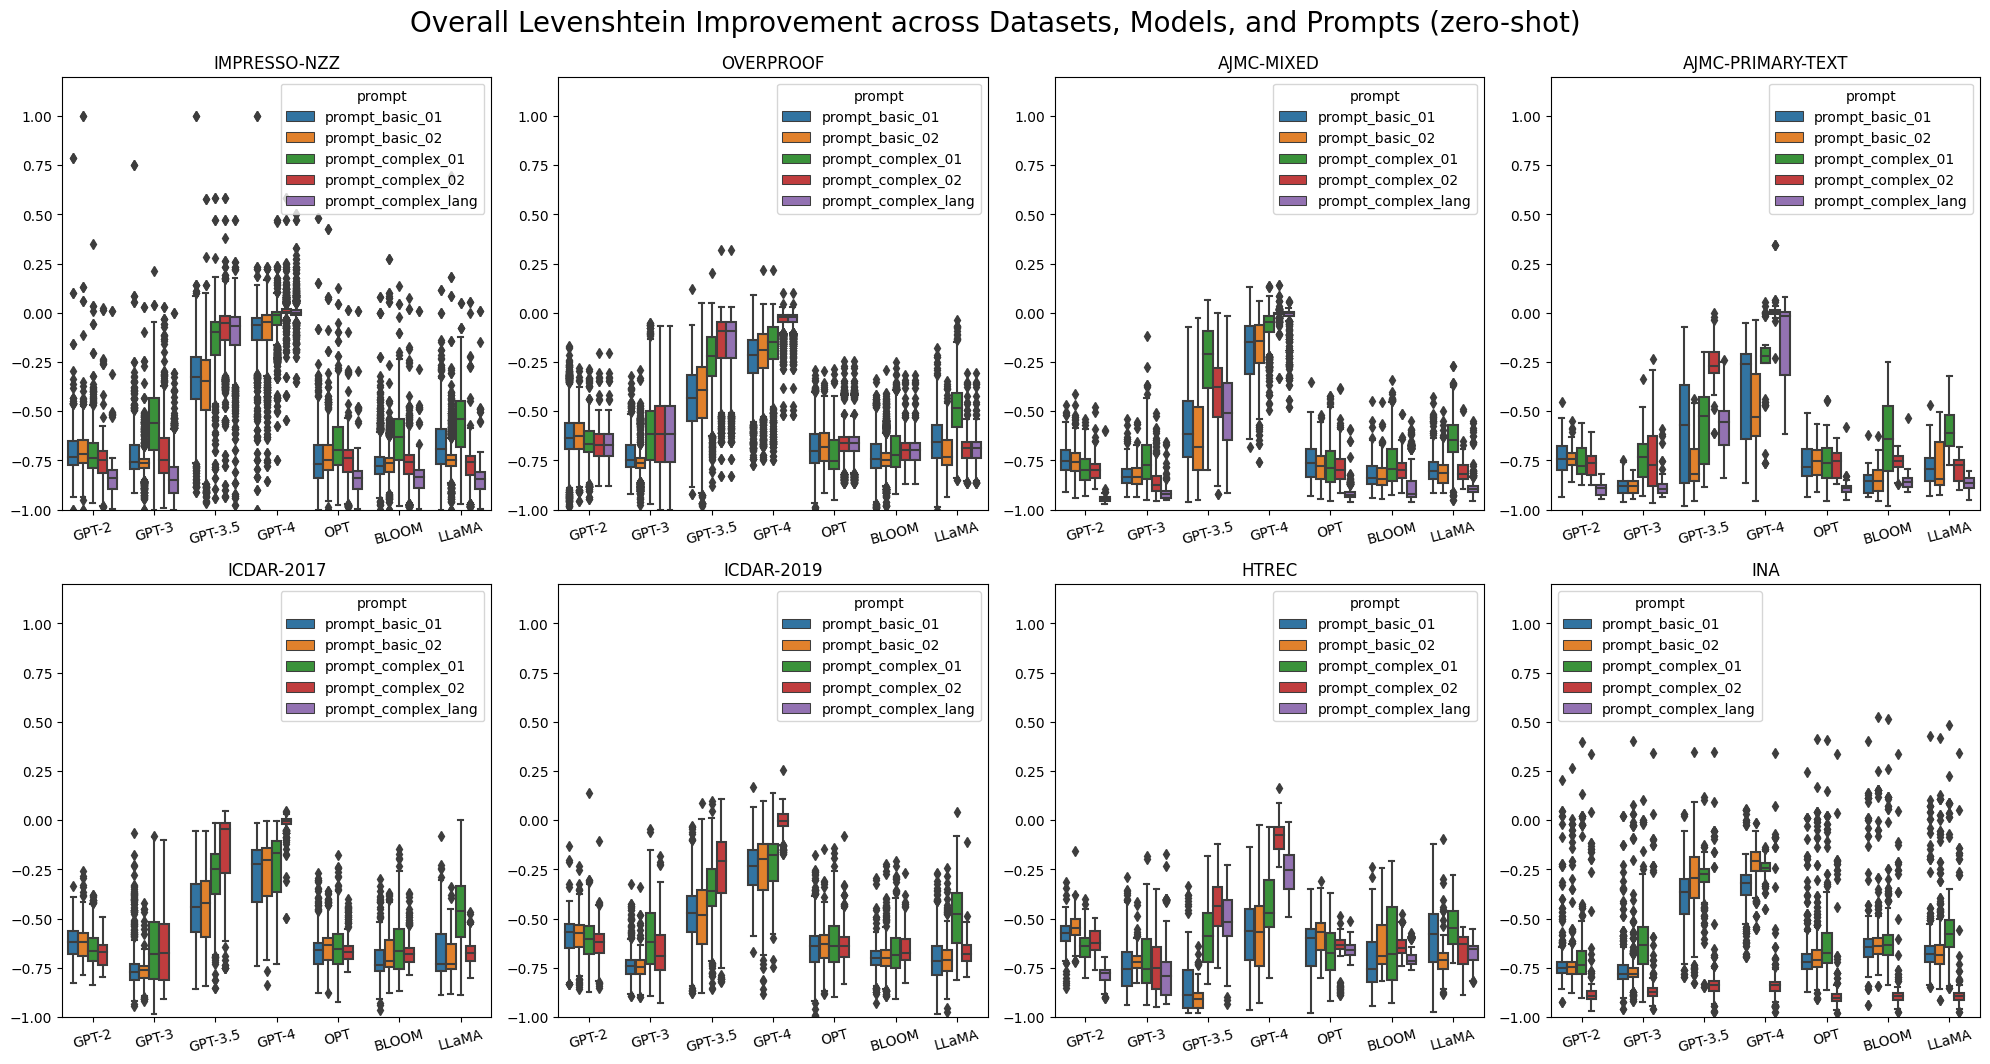

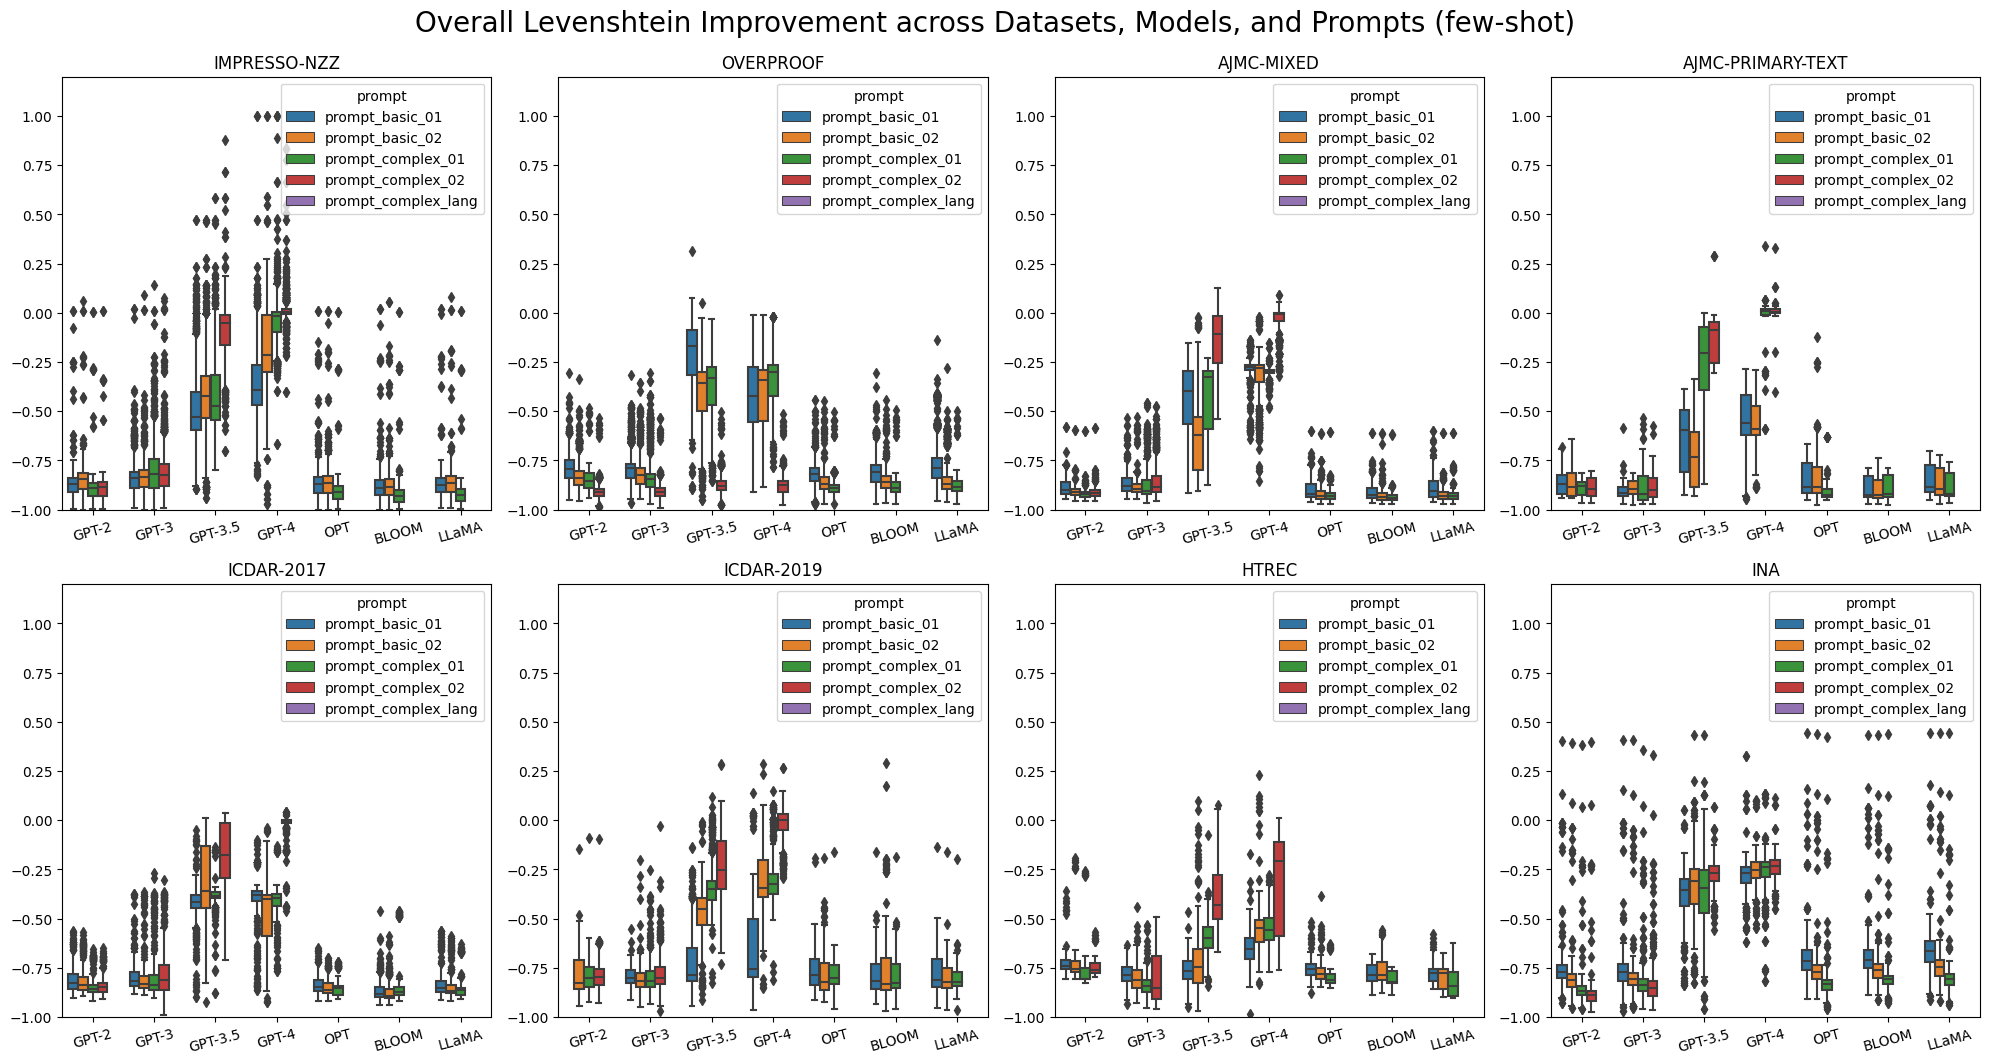

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Define OCR noise level bins
bins = [0, 0.4, 0.6, 0.8, 0.99, 1.0]

# Assign OCR noise level labels
labels = ["0-40%", "40-60%", "60-80%", "80-99%", "99-100%"]

# Count the number of unique datasets
n_datasets = data.dataset_name.nunique()
dataset_names = ['impresso-nzz', 'overproof', 'ajmc-mixed', 
                 'ajmc-primary-text', 'icdar-2017', 'icdar-2019', 'htrec', 'ina']

model_names = ['GPT-2', 'GPT-3', 'GPT-3.5', 'GPT-4', 'OPT', 'BLOOM', 'LLaMA']
prompt_names = ['prompt_basic_01', 'prompt_basic_02', 'prompt_complex_01', 
                'prompt_complex_02', 'prompt_complex_lang']

for type_of_experiment in ['zero-shot', 'few-shot']:
# for type_of_experiment in ['language-specific']:
    for error_rate in ['lev']:
        
        # Create subplots
        fig, axs = plt.subplots(3, 4, figsize=(20, 15))

        # Flatten the axes for easy iteration
        axs = axs.flatten()

        for i, dataset in enumerate(dataset_names):
            dataset_data = data[(data.dataset_name == dataset) & (data.type == type_of_experiment)]
            # Compute the mean WER across line, sentence, and region levels
            if 'icdar' not in dataset:
                dataset_data[f'Overall Levenshtein Improvement'] = dataset_data[[f'line-{error_rate}-improvement', 
                                                                  f'sentence-{error_rate}-improvement', 
                                                                  f'region-{error_rate}-improvement']].mean(axis=1)
            else:
                dataset_data[f'Overall Levenshtein Improvement'] = dataset_data[[f'sentence-{error_rate}-improvement', 
                                                              f'region-{error_rate}-improvement']].mean(axis=1)
            
#             print(dataset, dataset_data[f'Overall Levenshtein Improvement'].min(),
#                  dataset_data[f'Overall Levenshtein Improvement'].max())
            
            try:
                # Plot the distribution of improvements for each model
                _ = sns.boxplot(x='model', y=f'Overall Levenshtein Improvement', data=dataset_data, 
                                ax=axs[i], order=model_names, hue='prompt', hue_order=prompt_names)
                axs[i].set_title(f'{dataset.upper()}')

                axs[i].set_ylim([-1, 1.2])
                axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=15)  # Rotate x-axis labels
                axs[i].set_xlabel('')  # Remove x-axis label
                axs[i].set_ylabel('')  # Remove y-axis label
            except Exception as ex:
                print(f'Could not load {dataset} with {ex}')


        # Remove empty subplots
        for i in range(len(data.dataset_name.unique()), len(axs)):
            fig.delaxes(axs[i])

        plt.tight_layout()
        plt.suptitle(f'Overall Levenshtein Improvement across Datasets, Models, and Prompts ({type_of_experiment})', fontsize=20, y=1.02)
        plt.show()


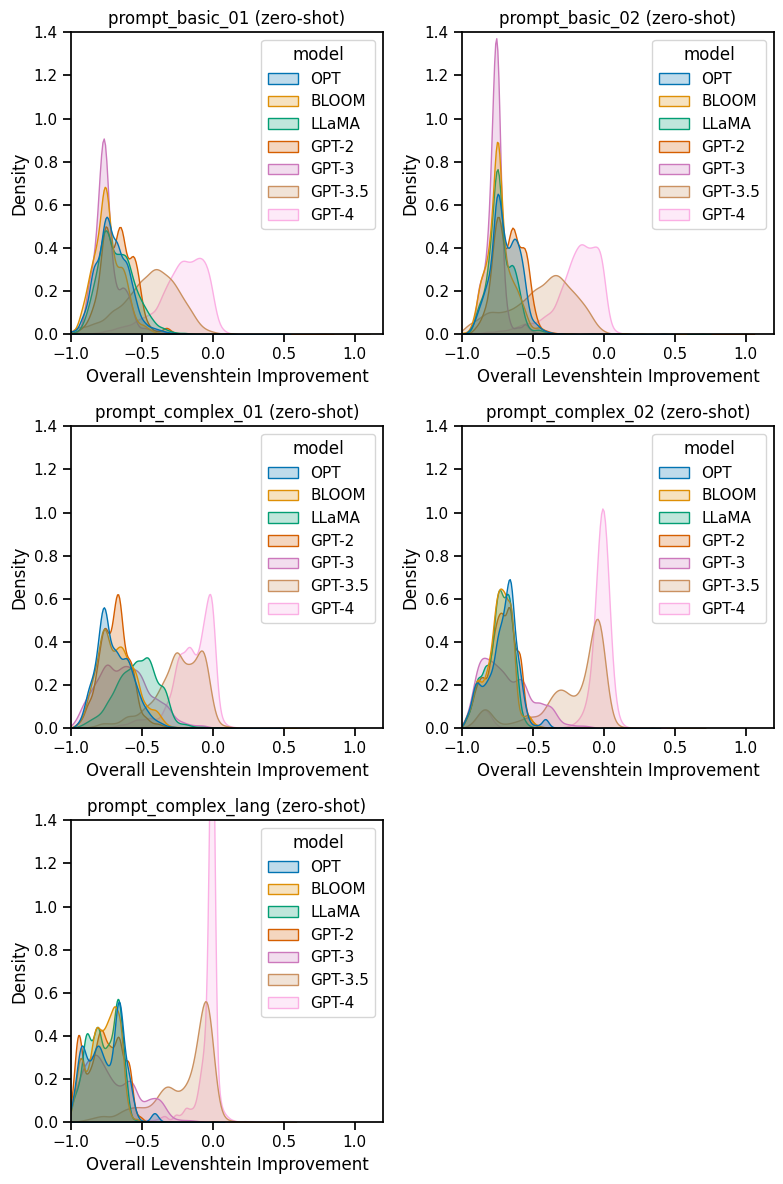

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette('colorblind')
sns.set_context("notebook", font_scale=1)

model_names = ['OPT', 'BLOOM', 'LLaMA', 'GPT-2', 'GPT-3', 'GPT-3.5', 'GPT-4']

for type_of_experiment in ['zero-shot']:
    for error_rate in ['lev']:
        fig, axs = plt.subplots(3, 2, figsize=(8, 12))  # Change here
        axs = axs.flatten()  # To make it easy to index

        for i, prompt in enumerate(prompt_names):
            prompt_data = data[(data.prompt == prompt) & (data.type == type_of_experiment)]
            
            if 'icdar' not in dataset:
                prompt_data[f'Overall Levenshtein Improvement'] = prompt_data[[f'line-{error_rate}-improvement', 
                                                                  f'sentence-{error_rate}-improvement', 
                                                                  f'region-{error_rate}-improvement']].mean(axis=1)
            else:
                prompt_data[f'Overall Levenshtein Improvement'] = prompt_data[[f'sentence-{error_rate}-improvement', 
                                                              f'region-{error_rate}-improvement']].mean(axis=1)

            try:
                if len(prompt_data) > 0:
                    sns.kdeplot(data=prompt_data, x=f'Overall Levenshtein Improvement', hue='model', 
                                fill=True, ax=axs[i], hue_order=model_names)
                    axs[i].set_title(f'{prompt} ({type_of_experiment})')
                    axs[i].set_xlim([-1, 1.2])
                    axs[i].set_ylim([0, 1.4])
            except Exception as ex:
                print(f'Could not plot {prompt} with {ex}')

        # Remove empty subplot
        fig.delaxes(axs[-1])  # Change here

        plt.tight_layout()
        plt.show()


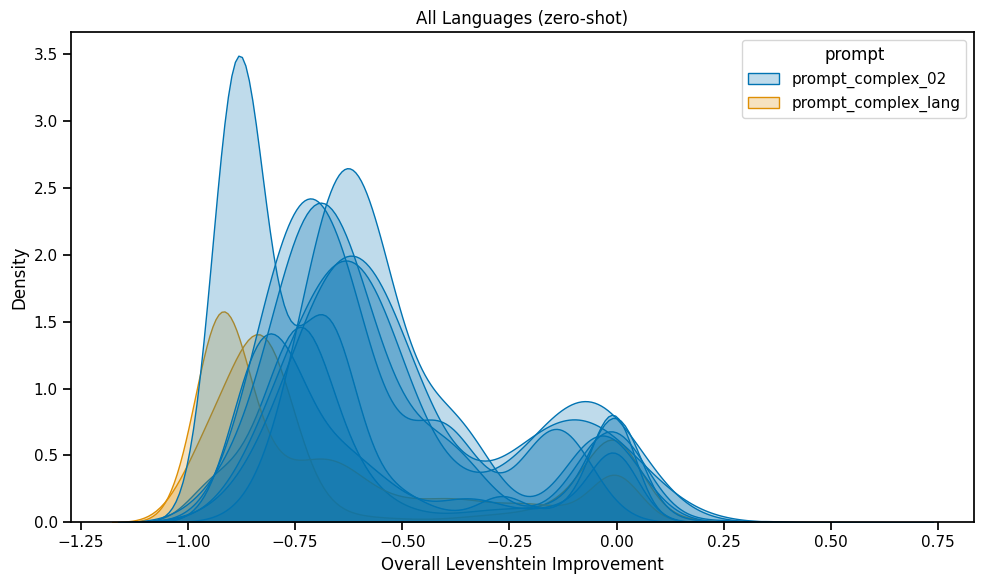

In [37]:
prompts_to_compare = ['prompt_complex_02', 'prompt_complex_lang']
languages = [lang for lang in data['language'].unique() if lang != 'en']  # Exclude 'en' language

for type_of_experiment in ['zero-shot']:
    for error_rate in ['lev']:
        plt.figure(figsize=(10, 6))  # Adjust as necessary

        for language in languages:
            language_data = data[(data.language == language) & 
                                 (data.type == type_of_experiment) & 
                                 (data.prompt.isin(prompts_to_compare))]

            if 'icdar' not in dataset:
                language_data[f'Overall Levenshtein Improvement'] = language_data[[f'line-{error_rate}-improvement', 
                                                                  f'sentence-{error_rate}-improvement', 
                                                                  f'region-{error_rate}-improvement']].mean(axis=1)
            else:
                language_data[f'Overall Levenshtein Improvement'] = language_data[[f'sentence-{error_rate}-improvement', 
                                                              f'region-{error_rate}-improvement']].mean(axis=1)

            try:
                if len(language_data) > 0:
                    sns.kdeplot(data=language_data, x=f'Overall Levenshtein Improvement', hue='prompt', 
                                fill=True, hue_order=prompts_to_compare)
            except Exception as ex:
                print(f'Could not plot {language} with {ex}')

        plt.title(f'All Languages ({type_of_experiment})')
        plt.tight_layout()
        plt.show()


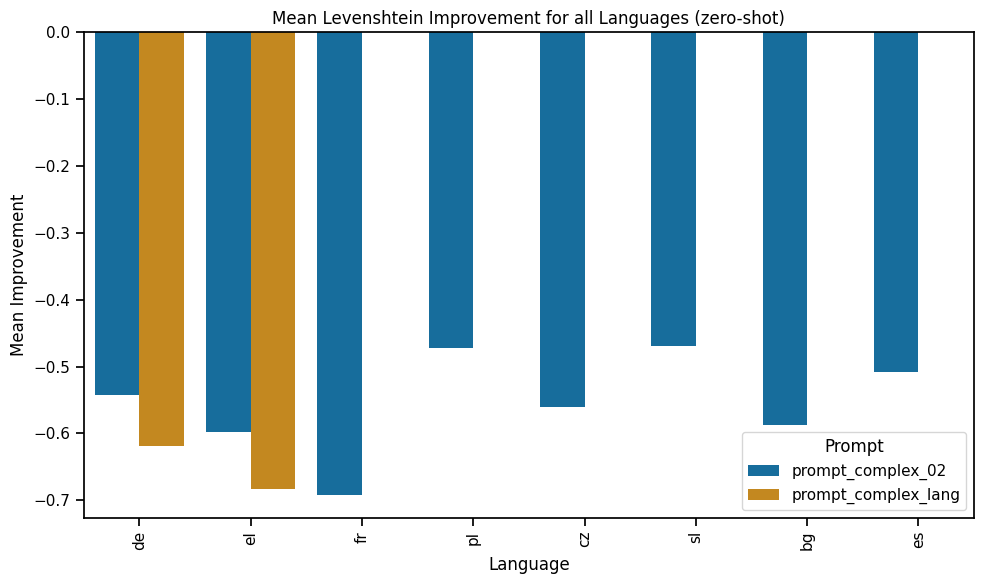

In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette('colorblind')
sns.set_context("notebook", font_scale=1.)


prompts_to_compare = ['prompt_complex_02', 'prompt_complex_lang']
languages = [lang for lang in data['language'].unique() if lang != 'en']  # Exclude 'en' language

bar_data = []

for type_of_experiment in ['zero-shot']:
    for error_rate in ['lev']:
        for language in languages:
            for prompt in prompts_to_compare:
                sub_data = data[(data.language == language) & 
                                 (data.type == type_of_experiment) & 
                                 (data.prompt == prompt)]
                if 'icdar' not in dataset:
                    sub_data[f'Overall Levenshtein Improvement'] = sub_data[[f'line-{error_rate}-improvement', 
                                                                          f'sentence-{error_rate}-improvement', 
                                                                          f'region-{error_rate}-improvement']].mean(axis=1)
                else:
                    sub_data[f'Overall Levenshtein Improvement'] = sub_data[[f'sentence-{error_rate}-improvement', 
                                                                      f'region-{error_rate}-improvement']].mean(axis=1)
                
                mean_improvement = np.mean(sub_data[f'Overall Levenshtein Improvement'])
                bar_data.append({'Language': language, 'Prompt': prompt, 'Mean Improvement': mean_improvement})

bar_data = pd.DataFrame(bar_data)

plt.figure(figsize=(10, 6))
sns.barplot(x='Language', y='Mean Improvement', hue='Prompt', data=bar_data, hue_order=prompts_to_compare)
plt.title(f'Mean Levenshtein Improvement for all Languages ({type_of_experiment})')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


In [39]:
data.dataset_name.unique()

array(['impresso-nzz', 'overproof', 'htrec', 'ajmc-mixed', 'icdar-2019',
       'icdar-2017', 'ina', 'ajmc-primary-text'], dtype=object)

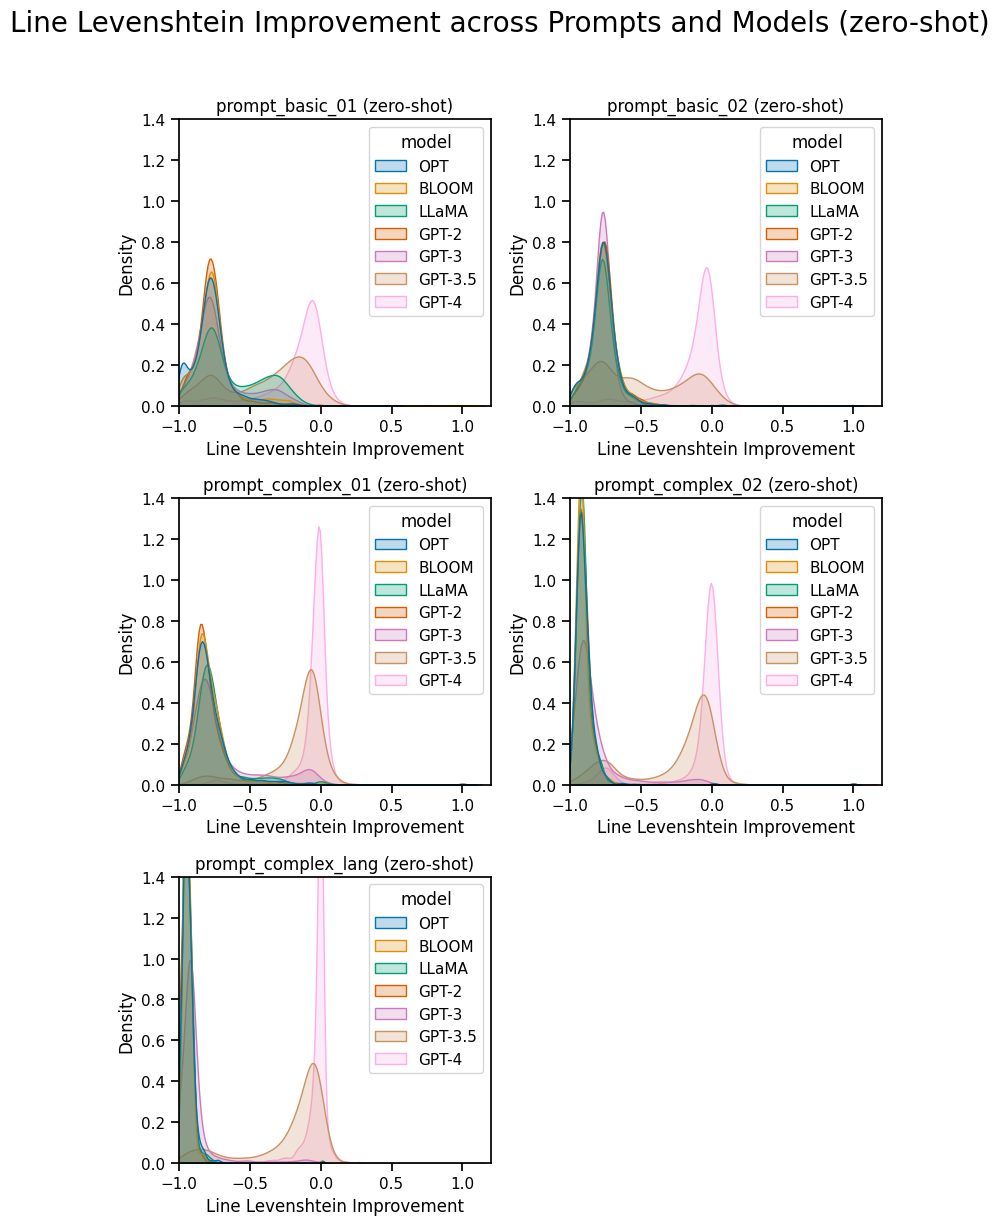

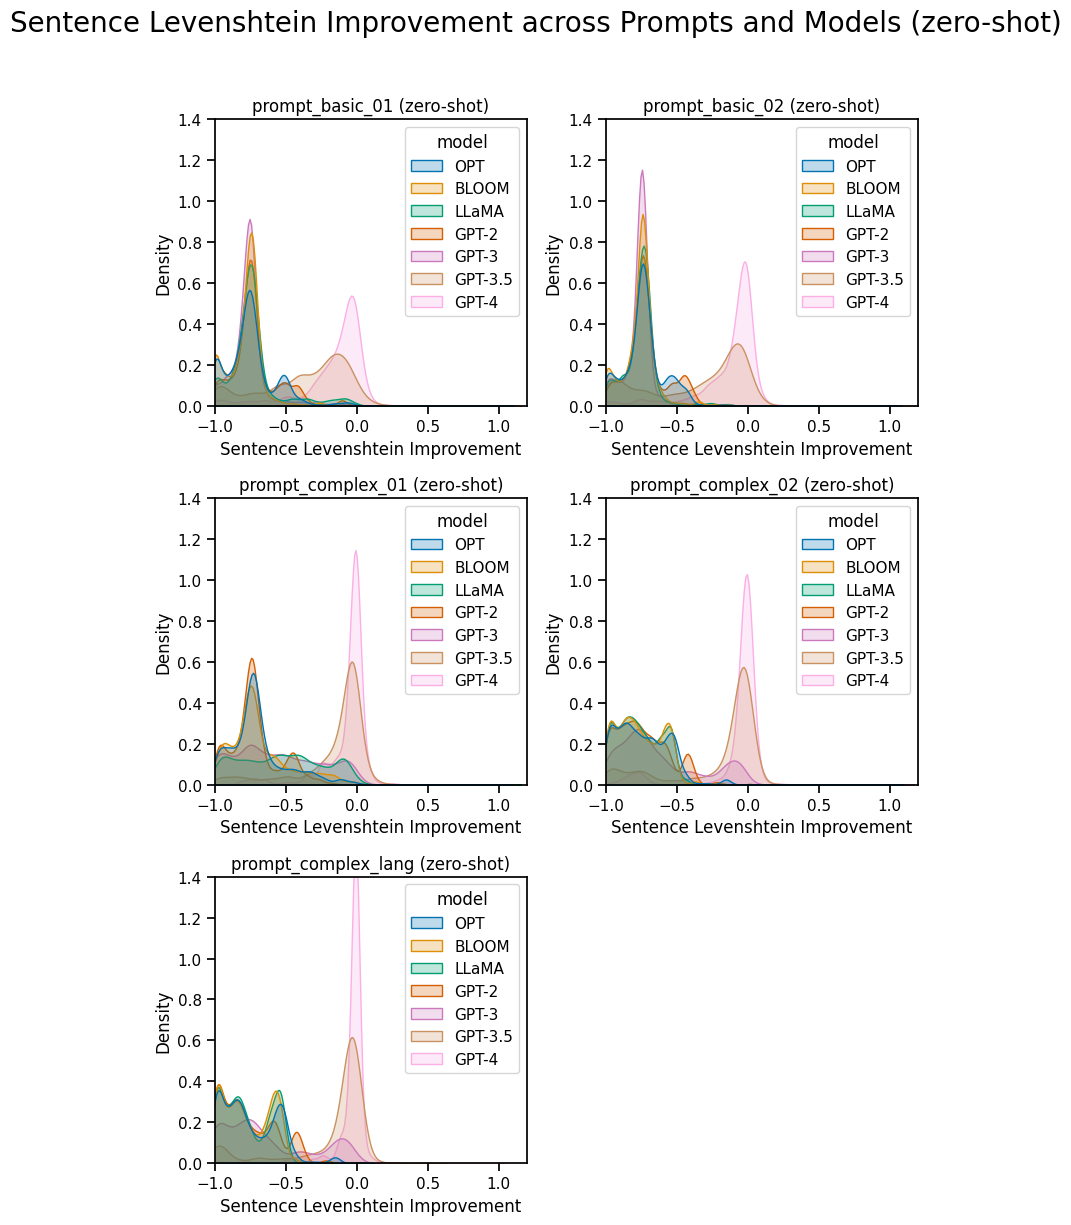

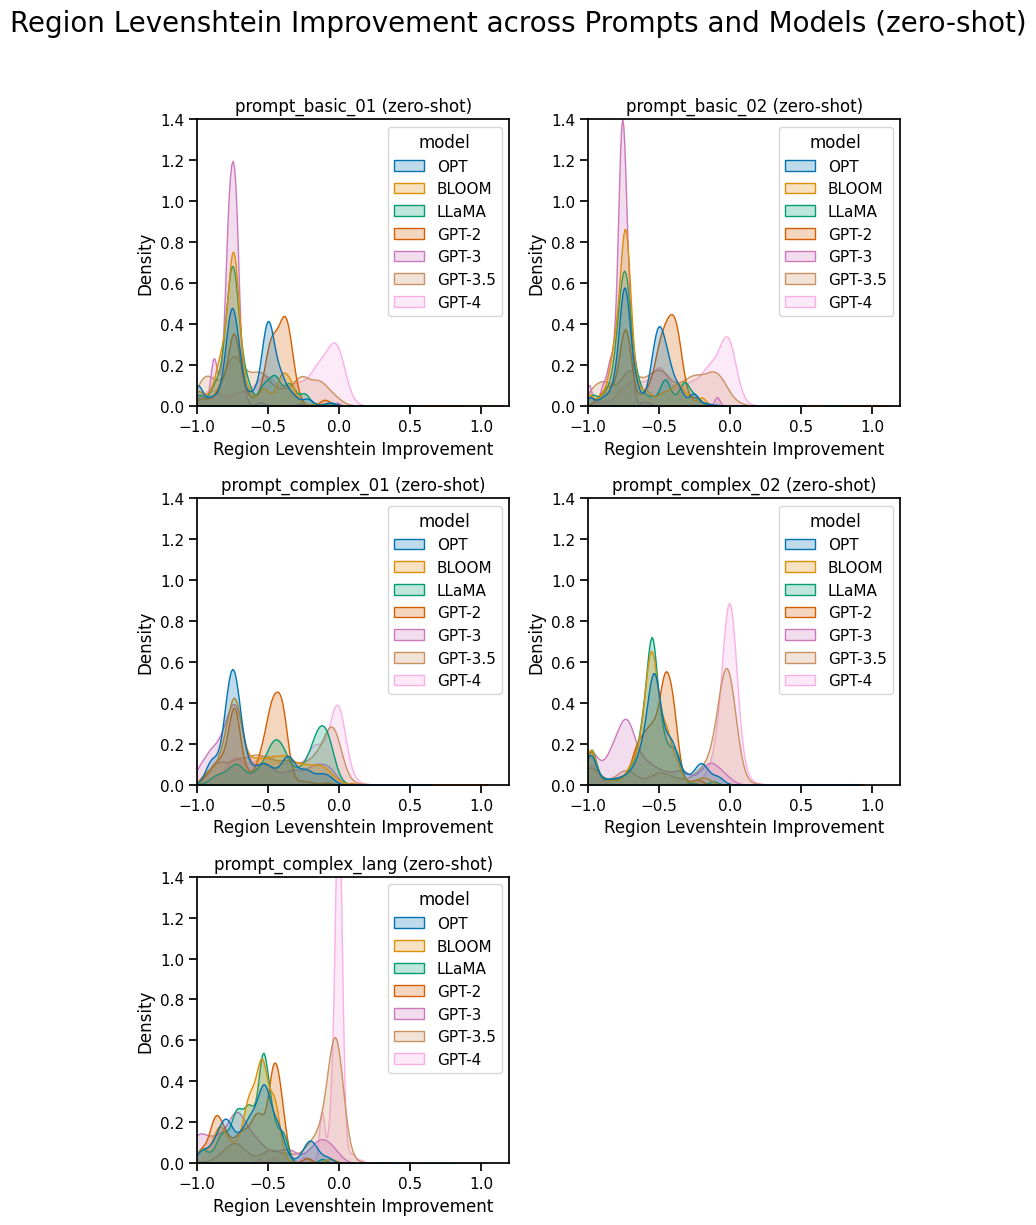

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette('colorblind')
sns.set_context("notebook", font_scale=1)

model_names = ['OPT', 'BLOOM', 'LLaMA', 'GPT-2', 'GPT-3', 'GPT-3.5', 'GPT-4']
segmentations = ['line', 'sentence', 'region']

for type_of_experiment in ['zero-shot']:
    for error_rate in ['lev']:
        for segmentation in segmentations:
            fig, axs = plt.subplots(3, 2, figsize=(8, 12))  # Change here
            axs = axs.flatten()  # To make it easy to index

            for i, prompt in enumerate(prompt_names):
                prompt_data = data[(data.prompt == prompt) & (data.type == type_of_experiment)]
                if segmentation == 'line':
                    prompt_data = prompt_data[~prompt_data.dataset_name.isin(['icdar-2017', 'icdar-2019'])]
                prompt_data[f'{segmentation.capitalize()} Levenshtein Improvement'] = prompt_data[f'{segmentation}-{error_rate}-improvement']

                try:
                    if len(prompt_data) > 0:
                        sns.kdeplot(data=prompt_data, x=f'{segmentation.capitalize()} Levenshtein Improvement', hue='model', 
                                    fill=True, ax=axs[i], hue_order=model_names)
                        axs[i].set_title(f'{prompt} ({type_of_experiment})')
                        axs[i].set_xlim([-1, 1.2])
                        axs[i].set_ylim([0, 1.4])
                except Exception as ex:
                    print(f'Could not plot {prompt} with {ex}')

            # Remove empty subplot
            fig.delaxes(axs[-1])  # Change here

            plt.suptitle(f'{segmentation.capitalize()} Levenshtein Improvement across Prompts and Models ({type_of_experiment})', fontsize=20, y=1.02)
            plt.tight_layout()
            plt.show()


In [41]:
data.columns

Index(['filename', 'dataset_name', 'ocr.line', 'ocr.sentence', 'ocr.region',
       'groundtruth.line', 'groundtruth.sentence', 'groundtruth.region',
       'prediction.prompt', 'prediction.line', 'prediction.sentence',
       'prediction.region', 'model', 'prompt', 'prompt_text', 'type',
       'language', 'length', 'line-lev-ocr', 'line-lev-pred',
       'line-lev-improvement', 'sentence-lev-ocr', 'sentence-lev-pred',
       'sentence-lev-improvement', 'region-lev-ocr', 'region-lev-pred',
       'region-lev-improvement', 'article_id', 'century', 'File', 'Date',
       'Type', 'NbAlignedChar', 'Quality Band',
       'Overall Levenshtein Improvement', 'Improvement Band'],
      dtype='object')

['Negative Improvement' 'Positive Improvement']
['Negative Improvement' 'Positive Improvement' 'No Improvement']
['Negative Improvement' 'Positive Improvement' 'No Improvement']
['Negative Improvement' 'No Improvement' 'Positive Improvement']
['Negative Improvement' 'Positive Improvement']
['Negative Improvement' 'Positive Improvement' 'No Improvement']
['Negative Improvement' 'Positive Improvement' 'No Improvement']
['Negative Improvement' 'Positive Improvement']
['Negative Improvement' 'Positive Improvement']
['Negative Improvement' 'Positive Improvement' 'No Improvement']
['No Improvement' 'Negative Improvement' 'Positive Improvement']
['Negative Improvement' 'Positive Improvement']
['Negative Improvement' 'Positive Improvement']
['Negative Improvement' 'Positive Improvement']


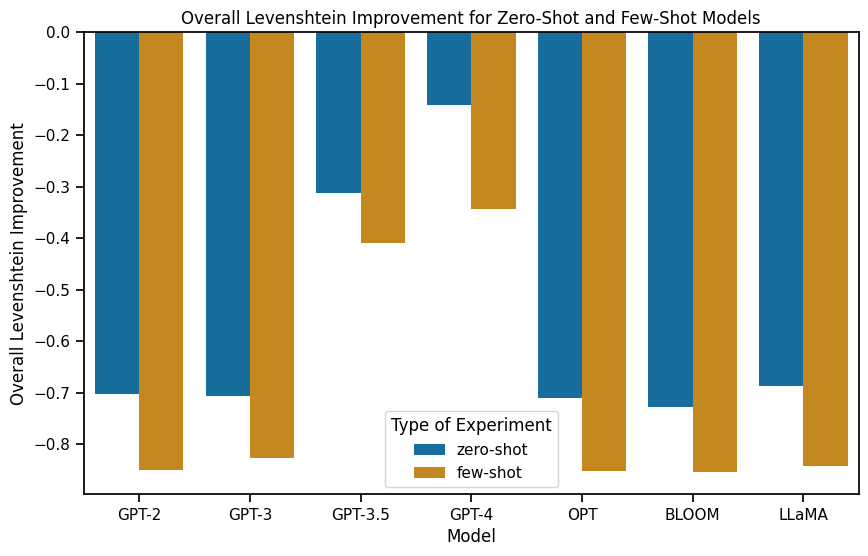

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

results = []  # Define results as a list

model_names = ['GPT-2', 'GPT-3', 'GPT-3.5', 'GPT-4', 'OPT', 'BLOOM', 'LLaMA']

for type_of_experiment in ['zero-shot', 'few-shot']:
    for model in model_names:
        model_data = data[(data.model == model) & (data.type == type_of_experiment)]
        
        # Compute the mean Levenshtein Improvement across line, sentence, and region levels
        if 'icdar' not in dataset:
            model_data['Overall Levenshtein Improvement'] = model_data[[f'line-lev-improvement', 
                                                                        f'sentence-lev-improvement', 
                                                                        f'region-lev-improvement']].mean(axis=1)
        else:
            model_data['Overall Levenshtein Improvement'] = model_data[[f'sentence-lev-improvement', 
                                                                        f'region-lev-improvement']].mean(axis=1)

        # Append the results
        print(model_data['Improvement Band'].unique())
        results.append({'Model': model,
                        'Type of Experiment': type_of_experiment,
                        'Overall Levenshtein Improvement': np.nanmean(model_data['Overall Levenshtein Improvement'])})

# Convert the results list to a DataFrame for plotting
results_df = pd.DataFrame(results)

# Create the plot
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='Overall Levenshtein Improvement', hue='Type of Experiment', data=results_df, order=model_names)
plt.title('Overall Levenshtein Improvement for Zero-Shot and Few-Shot Models')
plt.show()


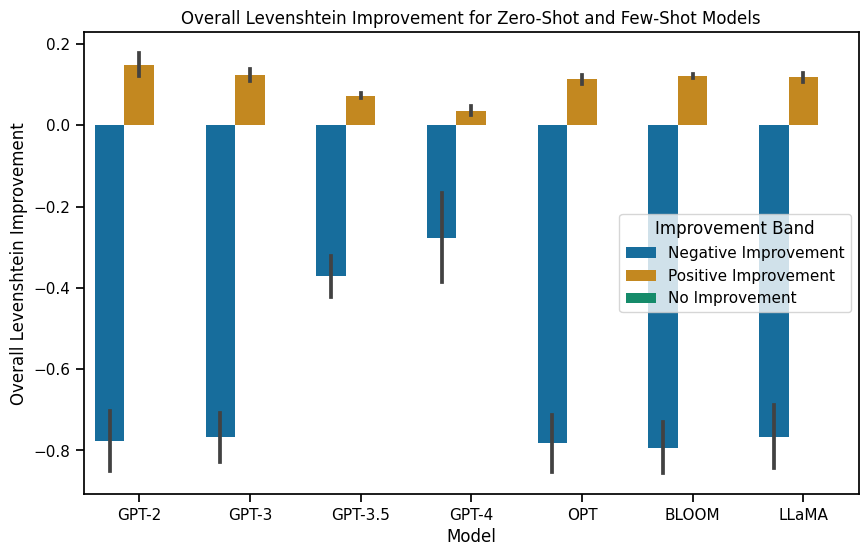

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

results = []  # Define results as a list

model_names = ['GPT-2', 'GPT-3', 'GPT-3.5', 'GPT-4', 'OPT', 'BLOOM', 'LLaMA']

for type_of_experiment in ['zero-shot', 'few-shot']:
    for model in model_names:
        for band in data['Improvement Band'].unique():
            model_band_data = data[(data.model == model) & (data.type == type_of_experiment) & (data['Improvement Band'] == band)]
            
            # Compute the mean Levenshtein Improvement across line, sentence, and region levels
            if 'icdar' not in dataset:
                model_band_data['Overall Levenshtein Improvement'] = model_band_data[[f'line-lev-improvement', 
                                                                                    f'sentence-lev-improvement', 
                                                                                    f'region-lev-improvement']].mean(axis=1)
            else:
                model_band_data['Overall Levenshtein Improvement'] = model_band_data[[f'sentence-lev-improvement', 
                                                                                    f'region-lev-improvement']].mean(axis=1)

            # Append the results
            results.append({'Model': model,
                            'Type of Experiment': type_of_experiment,
                            'Overall Levenshtein Improvement': np.nanmean(model_band_data['Overall Levenshtein Improvement']),
                            'Improvement Band': band})

# Convert the results list to a DataFrame for plotting
results_df = pd.DataFrame(results)

# Create the plot
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='Overall Levenshtein Improvement', hue='Improvement Band', 
            data=results_df, order=model_names)
plt.title('Overall Levenshtein Improvement for Zero-Shot and Few-Shot Models')
plt.show()


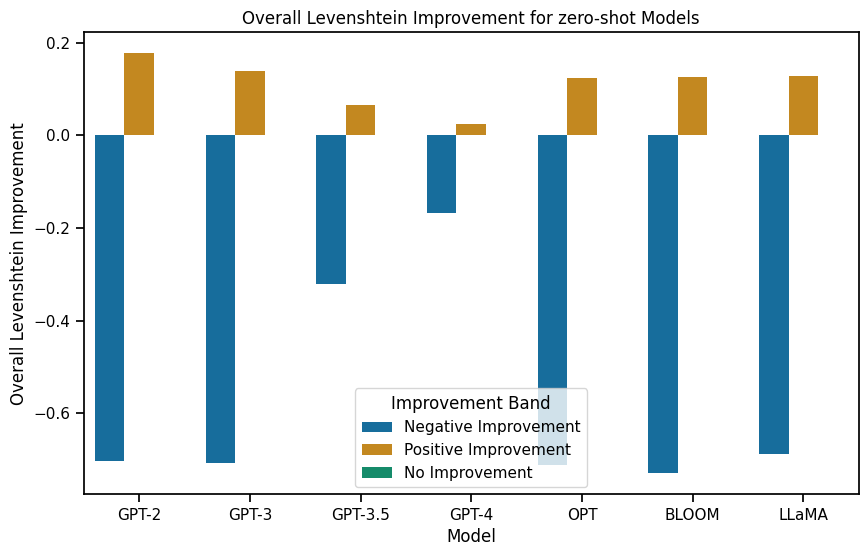

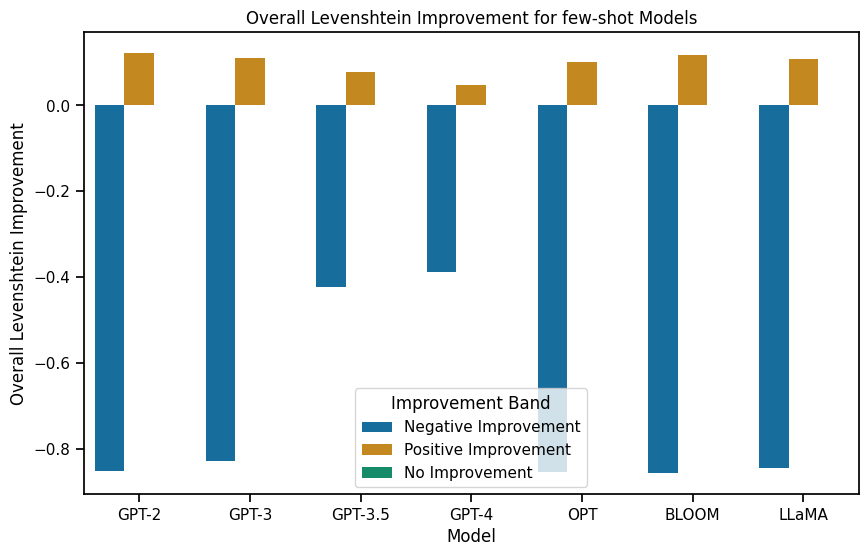

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

model_names = ['GPT-2', 'GPT-3', 'GPT-3.5', 'GPT-4', 'OPT', 'BLOOM', 'LLaMA']
improvement_bands = data['Improvement Band'].unique()

for type_of_experiment in ['zero-shot', 'few-shot']:
    plt.figure(figsize=(10, 6))
    experiment_data = results_df[results_df['Type of Experiment'] == type_of_experiment]
    
    sns.barplot(x='Model', y='Overall Levenshtein Improvement', hue='Improvement Band',
                data=experiment_data, order=model_names, hue_order=improvement_bands)
    
    plt.title(f'Overall Levenshtein Improvement for {type_of_experiment} Models')
    plt.show()


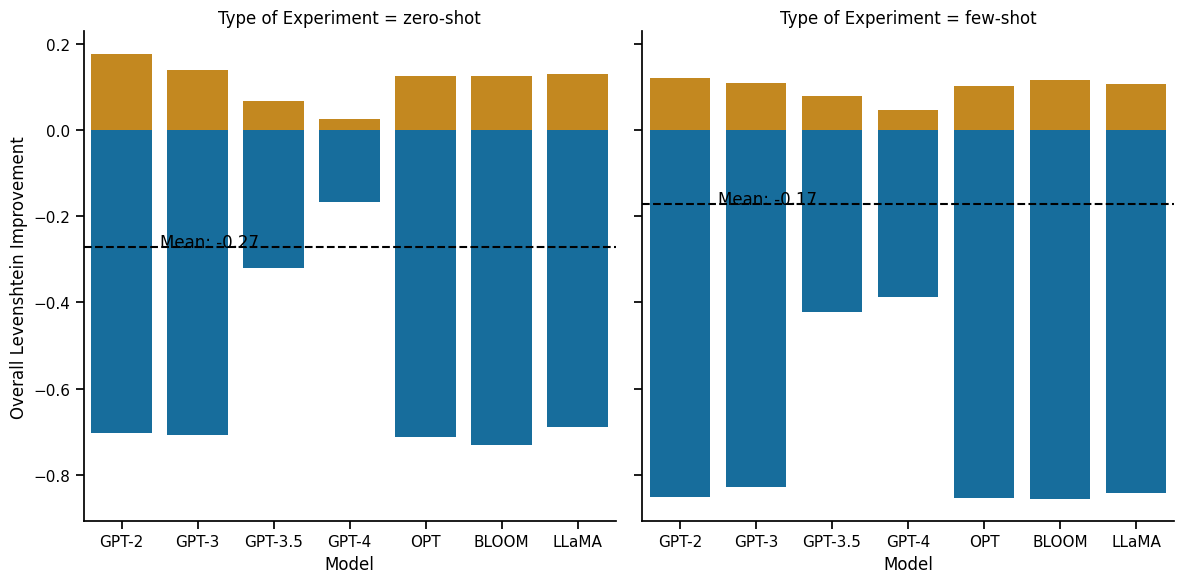

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

model_names = ['GPT-2', 'GPT-3', 'GPT-3.5', 'GPT-4', 'OPT', 'BLOOM', 'LLaMA']

g = sns.FacetGrid(results_df, col='Type of Experiment', hue='Improvement Band', height=6, aspect=1)
g.map(sns.barplot, 'Model', 'Overall Levenshtein Improvement', order=model_names)

# Calculate means for each type of experiment and add horizontal lines
for ax, (type_of_experiment, data) in zip(g.axes.flatten(), results_df.groupby('Type of Experiment')):
    mean_improvement = data['Overall Levenshtein Improvement'].mean()
    ax.axhline(mean_improvement, color='black', linestyle='--')
    ax.text(0.5, mean_improvement, f'Mean: {mean_improvement:.2f}', color='black')

plt.show()


In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

model_names = ['GPT-2', 'GPT-3', 'GPT-3.5', 'GPT-4', 'OPT', 'BLOOM', 'LLaMA']

for type_of_experiment in ['zero-shot', 'few-shot']:
    plt.figure(figsize=(10,6))
    
    experiment_data = data[data.type == type_of_experiment]
    sns.countplot(x='model', hue='Improvement Band', data=experiment_data, order=model_names)
    
    plt.title(f'Improvement Band counts for {type_of_experiment} Models')
    plt.show()


AttributeError: 'DataFrame' object has no attribute 'type'

<Figure size 1000x600 with 0 Axes>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_palette('colorblind')
sns.set_context("notebook", font_scale=1)

results = []  # Define results as a list

model_names = ['GPT-2', 'GPT-3', 'GPT-3.5', 'GPT-4', 'OPT', 'BLOOM', 'LLaMA']
level_names = ['line', 'sentence', 'region']

for type_of_experiment in ['zero-shot', 'few-shot']:
    for model in model_names:
        model_data = data[(data.model == model) & (data.type == type_of_experiment)]
        
        # Compute the mean Levenshtein Improvement across line, sentence, and region levels
        for level in level_names:
            if level == 'line' and 'icdar' in dataset:
                continue

            # Append the results
            results.append({'Model': model,
                            'Type of Experiment': type_of_experiment,
                            'Level': level.capitalize(),
                            'Levenshtein Improvement': np.nanmean(model_data[f'{level}-lev-improvement'])})
# Convert the results list to a DataFrame for plotting
results_df = pd.DataFrame(results)

# Create the plot
plt.figure(figsize=(10,6))
sns.catplot(x='Model', y='Levenshtein Improvement', hue='Type of Experiment', col='Level',
            data=results_df, kind='bar', order=model_names)
plt.suptitle('Levenshtein Improvement for Zero-Shot and Few-Shot Models', y=1.02)
plt.show()


In [ ]:
# Create subplots
fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(x='type', y='Overall Levenshtein Improvement', hue='model', 
            data=data, order=['zero-shot', 'few-shot'], hue_order=model_names)
ax.set_ylim([-1, 1.2])
ax.set_xticklabels(['Zero-Shot', 'Few-Shot'], rotation=0)
ax.set_xlabel('Type of Experiment')
ax.set_ylabel('Overall Levenshtein Improvement')
plt.legend(title='Model', loc='upper right')

plt.title('Overall Levenshtein Improvement across Type of Experiment and Models')
plt.tight_layout()
plt.show()


In [ ]:
data.columns

In [ ]:
# Create subplots

model_names = ['GPT-2', 'GPT-3', 'GPT-3.5', 'GPT-4', 'OPT', 'BLOOM', 'LLaMA']

for prompt in data.prompt.unique():

    fig, ax = plt.subplots(figsize=(10, 5))
    dataset = data[data.prompt == prompt]
    sns.boxplot(x='language', y='sentence-lev-improvement', hue='model', hue_order=model_names,
                data=dataset)
    ax.set_ylim([-1, 1.2])
    # ax.set_xticklabels(['Zero-Shot', 'Few-Shot'], rotation=0)
    ax.set_xlabel('language')
    ax.set_ylabel('sentence-lev-improvement')
    plt.legend(title='Model', loc='upper right')

    plt.title(f'Overall Levenshtein Improvement across Languages and Models ({prompt})')
    plt.tight_layout()
    plt.show()


In [ ]:
# correlation between quality band and imprevement band

In [ ]:
lev_improvement_summary = data.groupby(['dataset_name', 'model'])[['line-lev-improvement', 
                                                                   'sentence-lev-improvement', 
                                                                   'region-lev-improvement']].mean().reset_index()
# Compute the minimum and maximum Lev improvements for each dataset and model
min_lev_improvements = data.groupby(['dataset_name', 'model'])[['line-lev-improvement', 
                                                                   'sentence-lev-improvement', 
                                                                   'region-lev-improvement']].min().unstack()
max_lev_improvements = data.groupby(['dataset_name', 'model'])[['line-lev-improvement', 
                                                                   'sentence-lev-improvement', 
                                                                   'region-lev-improvement']].max().unstack()

# Create a new column for the average improvement across all segment types
lev_improvement_summary['Average Lev Improvement'] = lev_improvement_summary[['line-lev-improvement', 'sentence-lev-improvement', 'region-lev-improvement']].mean(axis=1)

# Combine the mean, min, and max improvements into one DataFrame
lev_improvements = pd.concat([lev_improvement_summary, min_lev_improvements, max_lev_improvements], 
                             keys=['Mean', 'Min', 'Max'])

# Convert the DataFrame to a LaTeX table
latex_table = lev_improvements.to_latex()

print(latex_table)

lev_improvement_summary.head()


In [ ]:
# Pivot the data so that models become columns and datasets become rows
lev_improvement_pivot = lev_improvement_summary.pivot(index='dataset_name', columns='model', values='Average Lev Improvement')

# Reset the index to make 'dataset_name' a regular column
lev_improvement_pivot.reset_index(inplace=True)

# Convert the DataFrame to LaTeX and print it
print(lev_improvement_pivot.to_latex(index=False))


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Define OCR noise level bins
# bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# bins = [0, 0.7, 0.8, 0.9, 1.0]

# Assign OCR noise level labels
# labels = ["0-10%", "10-20%", "20-30%", "30-40%", "40-50%", "50-60%", "60-70%", "70-80%", "80-90%", "90-100%"]
# labels = ["0-70%", "70-80%", "80-90%", "90-100%"]

bins = [0, 0.4, 0.6, 0.8, 0.99, 1.0]
labels = ["0-40%", "40-60%", "60-80%", "80-99%", "99-100%"]

# Count the number of unique datasets
n_datasets = data.dataset_name.nunique()
dataset_names = ['impresso-nzz', 'overproof', 'ajmc-mixed', 
                 'ajmc-primary-text', 'icdar-2017', 'icdar-2019', 'htrec', 'ina']

model_names = ['GPT-2', 'GPT-3', 'GPT-3.5', 'GPT-4', 'OPT', 'BLOOM', 'LLaMA']
prompt_names = ['prompt_basic_01', 'prompt_basic_02', 'prompt_complex_01', 'prompt_complex_02',
                'prompt_complex_lang']
segment_types = ['line', 'sentence', 'region']

for type_of_experiment in ['few-shot', 'zero-shot']:
    # Create subplots
    fig, axs = plt.subplots(n_datasets, len(segment_types), figsize=(20, 15))

    for i, dataset in enumerate(dataset_names):
        dataset_data = data[(data.dataset_name == dataset) & (data.type == type_of_experiment)]

        for j, segment_type in enumerate(segment_types):
            # Compute the segment type lev improvement
            dataset_data[f'{segment_type.capitalize()} Levenshtein Improvement'] = dataset_data[f'{segment_type}-{error_rate}-improvement']
            
            try:
                if type_of_experiment == 'language-specific':
                    # Plot the distribution of improvements for each model
                    _ = sns.boxplot(x='model', y=f'{segment_type.capitalize()} Levenshtein Improvement', data=dataset_data, 
                                ax=axs[i, j], order=model_names, hue='prompt')
                else:
                    _ = sns.boxplot(x='model', y=f'{segment_type.capitalize()} Levenshtein Improvement', data=dataset_data, 
                                ax=axs[i, j], order=model_names, hue='prompt', hue_order=prompt_names)
            except Exception as ex:
                print(f'Could not load {dataset} with {ex}')
            axs[i, j].set_title(f'{dataset.upper()} - {segment_type.capitalize()}')
#             axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=15)  # Rotate x-axis labels
            axs[i, j].set_xlabel('')  # Remove x-axis label
            axs[i, j].set_ylabel('')  # Remove y-axis label

            axs[i, j].set_ylim([-1.2, 1.2])
            # Remove the legend for all but the last subplot
            if i < n_datasets - 1 or j < len(segment_types):
                axs[i, j].legend().set_visible(False)


    # Add a legend outside of the plot area of the last subplot
    handles, labels = axs[-1, -1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.03), ncol=len(handles))

    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.08)  # Adjust the overall layout
    plt.suptitle(f'Levenshtein Improvement across Datasets, Models, Prompts, and Segment Types ({type_of_experiment})', fontsize=20)
    
    plt.show()

In [ ]:
# Define a list of quality bands
bins = [0, 0.4, 0.6, 0.8, 0.99, 1.0]
quality_bands = ["0-40%", "40-60%", "60-80%", "80-99%", "99-100%"]
dataset_names = ['impresso-nzz', 'overproof', 'ajmc-mixed', 
                 'ajmc-primary-text', 'icdar-2017', 'icdar-2019', 'htrec', 'ina']


for is_few_shot in [False]:
    # Create a figure and axes for subplots
    fig, axs = plt.subplots(len(quality_bands), len(dataset_names), figsize=(20, 15))

    # Flatten the axes for easy iteration
    axs = axs.flatten()

    # Create a counter
    i = 0
    # Iterate over all datasets
    for dataset in dataset_names:
        dataset_data = data[(data.dataset_name == dataset) & (data.type == is_few_shot)]

        # Iterate over all quality bands
        for band in quality_bands:
            # Filter data based on dataset and quality band
            subset = dataset_data[dataset_data['Quality Band'] == band]

            # Compute the mean Levenshtein Improvement across line, sentence, and region levels
            subset[f'Overall Levenshtein Improvement'] = subset[[f'line-lev-improvement', 
                                                              f'sentence-lev-improvement', 
                                                              f'region-lev-improvement']].mean(axis=1)

            # Plot the distribution of improvements for each model
            _ = sns.boxplot(x='model', y=f'Overall Levenshtein Improvement', data=subset, 
                        ax=axs[i], order=model_names, hue='prompt', hue_order=prompt_names)

            axs[i].set_title(f'{dataset.upper()} \n Quality Band {band}')

            axs[i].set_ylim([-1, 1.2])
            axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=15)  # Rotate x-axis labels
            axs[i].set_xlabel('')  # Remove x-axis label
            axs[i].set_ylabel('')  # Remove y-axis label

            i += 1

    # Remove empty subplots
    for j in range(i, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    if is_few_shot:
        plt.suptitle('Overall Levenshtein Improvement across Datasets, Models, Prompts, and Quality Bands (few-shot)', fontsize=20, y=1.02)
    else:
        plt.suptitle('Overall Levenshtein Improvement across Datasets, Models, Prompts, and Quality Bands', fontsize=20, y=1.02)
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a mapping from quality bands to numeric values
quality_band_mapping = {"0-40%": 1, "40-60%": 2, "60-80%": 3, "80-99%": 4, "99-100%": 5}

# Create a numeric quality band column based on the defined bins and labels
data["Quality Band"] = pd.cut(data['line-lev-ocr'], bins=[0, 0.4, 0.6, 0.8, 0.99, 1], labels=quality_band_mapping.keys())

# Add a numeric quality band column to the data
data["Numeric Quality Band"] = data["Quality Band"].map(quality_band_mapping)

# Compute the mean Levenshtein Improvement across line, sentence, and region levels
data['Overall Levenshtein Improvement'] = data[[f'line-lev-improvement', 
                                              f'sentence-lev-improvement', 
                                              f'region-lev-improvement']].mean(axis=1)

plt.figure(figsize=(12, 6))

# Generate scatter plot
sns.scatterplot(data=data, x='Numeric Quality Band', y='Overall Levenshtein Improvement', hue='model')

# Improve readability
plt.xticks(ticks=range(1, 6), labels=quality_band_mapping.keys())
plt.xlabel('Quality Band')
plt.ylabel('Overall Levenshtein Improvement')
plt.title('Levenshtein Improvement vs Quality Band')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the mean Levenshtein Improvement across line, sentence, and region levels
data['Overall Levenshtein Improvement'] = data[[f'line-lev-improvement', 
                                              f'sentence-lev-improvement', 
                                              f'region-lev-improvement']].mean(axis=1)

plt.figure(figsize=(12, 8))

# Generate violin plot
sns.violinplot(data=data, x='Quality Band', y='Overall Levenshtein Improvement', hue='dataset_name')

# Improve readability
plt.xlabel('Quality Band')
plt.ylabel('Overall Levenshtein Improvement')
plt.title('Levenshtein Improvement vs Quality Band for each Dataset')
plt.legend(title='Dataset', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
lev_improvement_threshold = -1.0

dataset = 'ajmc-mixed'

for is_few_shot in [True, False]:
    # Create subplots

    dataset_data = data[(data.dataset_name == dataset) & (data.type == is_few_shot)]
    segment_type = 'sentence'
    for error_rate in ['lev']:
        interesting_cases = dataset_data[dataset_data[f'{segment_type}-{error_rate}-improvement'] > lev_improvement_threshold]

        for _, interesting_cases in interesting_cases.iterrows():
            print('Segment type:', segment_type)
            print('Model:', interesting_cases['model'])
            print('Dataset:', interesting_cases['dataset_name'])
            print('Quality Band:', interesting_cases[f'Quality Band'])

            print('LEV ground-ocr', interesting_cases[f'{segment_type}-lev-ocr'], 
                  'LEV ground-pred', interesting_cases[f'{segment_type}-lev-pred'])
            print('LEV Improvement:', interesting_cases[f'{segment_type}-lev-improvement'])

            print('Ground:', interesting_cases[f'groundtruth.{segment_type}'][:50])
            print('OCR:', interesting_cases[f'ocr.{segment_type}'][:50])
            print('Pred:', interesting_cases[f'prediction.{segment_type}'])
            print('--'*50)


In [ ]:
dataset

In [ ]:
dataset[f'sentence-lev-improvement']

In [ ]:
data.dataset_name.unique()

In [ ]:
data.model.unique()

### ICDAR

In [ ]:
icdar_2017 = data[data.dataset_name == 'icdar-2017']

def get_document_type(filename):
    document_type = filename.split('/')[-2].replace('_', '-')
    return document_type

icdar_2017['document_type'] = icdar_2017['filename'].apply(lambda x: get_document_type(x))

icdar_2017.head()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Get the first dataset name
dataset_name = 'ICDAR-2017'

dataset_data = icdar_2017

model_names = ['GPT-2', 'GPT-3', 'GPT-3.5', 'GPT-4', 'OPT', 'BLOOM', 'LLaMA']
prompt_names = ['prompt_basic_01', 'prompt_basic_02', 'prompt_complex_01']
segment_types = ['sentence', 'region']
document_types = dataset_data['document_type'].unique()  # Get the unique document types

for error_rate in ['lev']:
    # Create subplots
    fig, axs = plt.subplots(len(segment_types), len(document_types), figsize=(20, 15))

    for i, segment_type in enumerate(segment_types):
        for j, document_type in enumerate(document_types):
            # Select data for the current document type
            document_data = dataset_data[dataset_data.document_type == document_type]

            # Compute the segment type lev improvement
            document_data[f'{segment_type.capitalize()} Levenshtein Improvement'] = document_data[f'{segment_type}-{error_rate}-improvement']

            # Plot the distribution of improvements for each model
            _ = sns.boxplot(x='model', y=f'{segment_type.capitalize()} Levenshtein Improvement', data=document_data, 
                        ax=axs[i, j], order=model_names, hue='prompt', hue_order=prompt_names)

            axs[i, j].set_title(f'{dataset_name.upper()} - {segment_type.capitalize()} - {document_type}')
            axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=15)  # Rotate x-axis labels
            axs[i, j].set_xlabel('')  # Remove x-axis label
            axs[i, j].set_ylabel('')  # Remove y-axis label
            axs[i, j].set_ylim([-1, 1])  # Set y-axis limits

            # Remove the legend for all but the last subplot
            if i < len(segment_types) - 1 or j < len(document_types) - 1:
                axs[i, j].legend().set_visible(False)

    # Add a legend outside of the plot area of the last subplot
    handles, labels = axs[-1, -1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.03), ncol=len(handles))

    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.08)  # Adjust the overall layout
    plt.suptitle('Levenshtein Improvement across Document Types, Models, Prompts, and Segment Types', fontsize=20)
    plt.show()


In [ ]:
icdar_2019 = data[data.dataset_name == 'icdar-2019']

def get_document_type(filename):
    document_type = filename.split('/')[-3]
    return document_type

icdar_2019['document_type'] = icdar_2019['filename'].apply(lambda x: get_document_type(x))

icdar_2019.head()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Get the first dataset name
dataset_name = 'ICDAR-2019'

dataset_data = icdar_2019

model_names = ['GPT-2', 'GPT-3', 'GPT-3.5', 'GPT-4', 'OPT', 'BLOOM', 'LLaMA']
prompt_names = ['prompt_basic_01', 'prompt_basic_02', 'prompt_complex_01']
segment_types = ['sentence', 'region']
document_types = dataset_data['document_type'].unique()  # Get the unique document types

n_rows = -(-len(segment_types) * len(document_types) // 4)  # Calculate the number of rows needed

for error_rate in ['lev']:
    # Create subplots
    fig, axs = plt.subplots(n_rows, 4, figsize=(20, 15))
    axs = axs.flatten()  # Flatten the axes for easy iteration

    for i, (segment_type, document_type) in enumerate([(st, dt) for st in segment_types for dt in document_types]):
        # Select data for the current document type
        document_data = dataset_data[dataset_data.document_type == document_type]

        # Compute the segment type lev improvement
        document_data[f'{segment_type.capitalize()} Levenshtein Improvement'] = document_data[f'{segment_type}-{error_rate}-improvement']

        # Plot the distribution of improvements for each model
        _ = sns.boxplot(x='model', y=f'{segment_type.capitalize()} Levenshtein Improvement', data=document_data, 
                    ax=axs[i], order=model_names, hue='prompt', hue_order=prompt_names)

        axs[i].set_title(f'{dataset_name.upper()} - {segment_type.capitalize()} - {document_type}')
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=15)  # Rotate x-axis labels
        axs[i].set_xlabel('')  # Remove x-axis label
        axs[i].set_ylabel('')  # Remove y-axis label
        axs[i].set_ylim([-1, 1])  # Set y-axis limits

        # Remove the legend for all but the last subplot
        if i < len(axs) - 1:
            axs[i].legend().set_visible(False)

    # Remove extra subplots
    for i in range(len(segment_types) * len(document_types), len(axs)):
        fig.delaxes(axs[i])

    # Add a legend outside of the plot area of the last subplot
    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.03), ncol=len(handles))

    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.08)  # Adjust the overall layout
    plt.suptitle('Levenshtein Improvement across Document Types, Models, Prompts, and Segment Types', fontsize=20)
    plt.show()


### AJMC

In [ ]:
ajmc_mixed = data[data.dataset_name == 'ajmc-mixed']

def get_document_type(filename):
    print(filename)
#     document_type = filename.split('/')[-3]
    return filename

ajmc_mixed['document_type'] = ajmc_mixed['filename'].apply(lambda x: get_document_type(x))

ajmc_mixed.head()

In [ ]:
ajmc_mixed

In [ ]:
# for idx, result in enumerate(results):
for segment_type in ['line', 'sentence', 'region']:
    print(segment_type, 'level', '*'*50)
    try:
        improved_texts = dataset[dataset['model'] == 'GPT-4'] 
        impooved_texts = improved_texts[improved_texts[f'{segment_type}-lev-improvement'] >= 0.7]
        #result[result[f'{segment_type}-lev-improvement'] >= 0.3]
        for _, improved_text in improved_texts.iterrows():
            print('Model:', improved_texts['model'].unique()[0])
            print('Dataset:', improved_texts['dataset_name'].unique()[0])
            print('Quality Band:', improved_text[f'{segment_type}-ocr-noise-group'])

            print('LEV ground-ocr', improved_text[f'{segment_type}-lev-ocr'], 
                  'LEV ground-pred', improved_text[f'{segment_type}-lev-pred'])
            print('LEV Improvement:', improved_text[f'{segment_type}-lev-improvement'])
            print('CER Improvement:', improved_text[f'{segment_type}-cer-improvement'])
            print('WER Improvement:', improved_text[f'{segment_type}-wer-improvement'])

            print('Ground:', improved_text[f'groundtruth.{segment_type}'][:50])
            print('OCR:', improved_text[f'ocr.{segment_type}'][:50])
            print('Pred:', improved_text[f'prediction.{segment_type}'])
            print('--'*50)
    except:
        continue
        

In [ ]:
data.columns

In [ ]:
for 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set the colorblind color palette
sns.set_palette("colorblind")
plt.figure(figsize=(12, 6))

for model in data['model'].unique():
    data_per_model = data[data['model'] == model]
    for segment_type in ['line', 'sentence', 'region']:
        # Filter the data by dataset and segment type
        fig, ax = plt.subplots(figsize=(12, 6))

        # Create the box plot
        sns.boxplot(x=f'{segment_type}-ocr-noise-group', y=f'{segment_type}-lev-improvement', 
                    data=data_per_model, hue='dataset_name', palette='colorblind', ax=ax)

        # Set the plot title and axis labels
        plt.title(f'Levenshtein Distance Improvement for {segment_type.capitalize()} Segments ({model})')
        plt.xlabel('Quality Bands')
        plt.ylabel('Levenshtein Distance Improvement')
        
        plt.ylim((-0.5, 1.5))
        # Show the plot
        plt.show()



In [ ]:
for model in data['dataset_name'].unique():
    data_per_model = data[data['dataset_name'] == model]
    for segment_type in ['line', 'sentence', 'region']:
        # Filter the data by dataset and segment type
        fig, ax = plt.subplots(figsize=(12, 6))

        # Create the box plot
        sns.boxplot(x=f'{segment_type}-ocr-noise-group', y=f'{segment_type}-lev-improvement', 
                    data=data_per_model, hue='model', palette='colorblind', ax=ax)

        # Set the plot title and axis labels
        plt.title(f'Levenshtein Distance Improvement for {segment_type.capitalize()} Segments ({model})')
        plt.xlabel('Quality Bands')
        plt.ylabel('Levenshtein Distance Improvement')
        
        plt.ylim((-0.2, 1.0))
        # Show the plot
        plt.show()



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set the colorblind color palette
sns.set_palette("colorblind")
plt.figure(figsize=(12, 6))

for result in results:
    
    dataset_name = result['dataset_name'].unique()[0]
    
    for segment_type in ['line', 'sentence', 'region']:
        
        #grouped_results = result.groupby([f"{segment_type}-ocr-noise-group", "dataset_name"]).size().reset_index(name="count")
        
        grouped_results = result.groupby([f"{segment_type}-ocr-noise-group", "dataset_name"])[f"{segment_type}-lev-improvement"].mean().reset_index()

        print(grouped_results.head())
        
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        _ = sns.lineplot(x=f"{segment_type}-ocr-noise-group", y=f'{segment_type}-lev-improvement', hue='dataset_name',
                 data=grouped_results, ax=ax, markers=True, linestyle='-', linewidth=2.5)


        # Set plot labels
        ax.set_xlabel(f"{dataset_name} Ground Truth {segment_type.capitalize()}")
        ax.set_ylabel(f"{dataset_name} {segment_type.capitalize()} Improvement")
        ax.set_title(f"{dataset_name} Levenshtein Improvement for {segment_type.capitalize()} OCR Examples")


        # Show the plot
        plt.show()

